# Bibliotecas

In [ ]:
# Bibliotecas mais comuns
import pandas as pd
import numpy as np
import os, time
import random
import statistics
import openpyxl
import sys

# Bibliotecas para leitura e processamentos dos dados
import statsmodels.api as sm
import pickle

# Bibliotecas para criação de gráficos
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import randint
from matplotlib.lines import Line2D

# Bibliotecas para o Projeto RMN
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funções

## Processamento dos dados Crus

In [ ]:
def TratamentoDadosNiumag (diretorio_pasta, arquivo_niumag, inicio_conversao, pontos_inversao,
                           Pasta_Salvamento = None, Salvar = False, Data = None, T2_niumag_gm = False,
                           T2_niumag_av = False):

    niumag = str(diretorio_pasta) + str(arquivo_niumag)                           # Pasta do arquivp
    dados_niumag = pd.read_excel(niumag).drop('File Name', axis=1)                # Dataframe dos Dados da Niumag

    inicio = inicio_conversao-2                                                   # Linha que se inicia os dados de da inversão
    final = inicio+pontos_inversao                                                # Linha final da Inversão

    amostras = []
    tempo_distribuicao = []
    distribuicao_t2 = []
    t2gm_niumag = []
    t2av_niumag = []
    fitting_erro = []
    fracao_argila = []
    poço = []
    amplitudes = []

    for i in np.arange(int(len(dados_niumag.columns)/7)):
        df = dados_niumag.T.reset_index().drop('index', axis = 1).T
        nome = dados_niumag.columns[i*7][:9]
        tempo = df[i*7+3][inicio:final]
        distribuicao = df[i*7+4][inicio:final]
        gm = float(df[i*7+2][1][7:-4])
        av = float(df[i*7+2][2][7:-4])
        fit_erro = float(df[i*7][0][-5:])
        argila = sum(distribuicao[:53])/sum(distribuicao)
        p = nome[:4]
        amp = df[i*7+2][5:10].fillna(0).nlargest(3)
        amostras.append(nome)
        poço.append(p)
        tempo_distribuicao.append(list(tempo))
        distribuicao_t2.append(list(distribuicao))
        t2gm_niumag.append(gm)
        t2av_niumag.append(av)
        fitting_erro.append(fit_erro)
        fracao_argila.append(argila)
        amplitudes.append(amp)

    dados = pd.DataFrame({'Amostra': amostras})
    dados['Poço'] = poço
    dados['Tempo Distribuicao'] = pd.Series(tempo_distribuicao)
    dados['Distribuicao T2'] = pd.Series(distribuicao_t2)
    dados['Fracao Argila'] =  fracao_argila
    dados['Fitting Error'] = fitting_erro
    dados['Amplitude'] = amplitudes

    if T2_niumag_gm == True:
        dados['T2 Geometrico Niumag'] = t2gm_niumag

    if T2_niumag_av == True:
        dados['T2 Medio Niumag'] = t2av_niumag


    dados = dados.sort_values(by = 'Amostra')

    if Salvar == True:
        local_salvamento = Pasta_Salvamento + 'Dados_Niumag_' + arquivo_niumag[:-5] + '_' + Data + '.xlsx'
        dados.to_excel(local_salvamento, sheet_name='Dados')                          # Salvar dataframe

    return dados

def TratamentoDadosLaboratorio (diretorio_pasta, dados_niumag, arquivo_laboratorio,
                                Pasta_Salvamento = None, Salvar = False, Data = None,
                                Fracoes_T2Han = False, Fracoes_T2Ge = False, BVIFFI = False,
                                Amplitude = False, Dados_porosidade_Transverso = False):
    laboratorio = str(diretorio_pasta) + str(arquivo_laboratorio)
    dados_niumag = dados_niumag
    dados_lab = pd.read_excel(laboratorio)


    amostras = dados_niumag['Amostra']
    tempo_distribuicao = dados_niumag['Tempo Distribuicao']
    distribuicao_t2 = dados_niumag['Distribuicao T2']
    fitting_erro = dados_niumag['Fitting Error']
    fracao_argila = dados_niumag['Fracao Argila']
    porosidade_i = []
    poço = dados_niumag['Poço']
    media_ponderada_log = []
    s1h = []
    s2h = []
    s3h = []
    s4h = []
    s1g = []
    s3g = []
    s4g = []
    BVI = []
    FFI = []
    A1 = []
    A2 = []
    A3 = []

    codi_lab = preprocessing.LabelEncoder()
    categoria_lito = codi_lab.fit_transform(dados_lab['Litofacies'])
    onehot = OneHotEncoder()
    ohe = pd.DataFrame(onehot.fit_transform(dados_lab[['Litofacies']]).toarray())
    ohe.columns = onehot.categories_


    for i in np.arange(len(distribuicao_t2)):
        t2_transpose = pd.DataFrame([distribuicao_t2[i]]).T
        scaler = pd.DataFrame(MaxAbsScaler().fit_transform(t2_transpose))
        scaler_sum_phi = float(dados_lab['Porosidade RMN'][i])/float(scaler.sum())
        phi_i = []
        for j in np.arange(len(scaler)):
            p = float(scaler[0][j]*scaler_sum_phi)
            phi_i.append(p)
        porosidade_i.append(list(phi_i))

    for i in np.arange(len(porosidade_i)):
        phi_i = porosidade_i[i]
        tempo_log = np.log(tempo_distribuicao[i])
        produto_porosidade_t2_log = pd.DataFrame(phi_i*tempo_log)
        sum_num = np.sum(produto_porosidade_t2_log)
        sum_den = np.sum(phi_i)
        razao_t2 = float(np.exp(sum_num/sum_den))
        media_ponderada_log.append((razao_t2))

    dados = pd.DataFrame({'Amostra': amostras})
    dados['Poço'] = poço
    dados['Litofacies'] = dados_lab['Litofacies']
    dados['Categoria Litofacies'] = categoria_lito
    dados['Bioturbiditos'] = ohe['Bioturbated']
    dados['Dolowackstone'] = ohe['Dolowackstone']
    dados['Grainstone'] = ohe['Grainstone']
    dados['Brechado'] = ohe['Brechado']
    dados['Packstone'] = ohe['Packstone']
    #dados['Artificial'] = ohe['Artificial']
    dados['Tempo Distribuicao'] = pd.Series(tempo_distribuicao)
    dados['Distribuicao T2'] = pd.Series(distribuicao_t2)
    dados['Porosidade i'] = pd.Series(porosidade_i)
    dados['Porosidade Gas'] = dados_lab['Porosidade Gas']/100
    dados['Porosidade RMN'] = dados_lab['Porosidade RMN']/100
    dados['Permeabilidade Gas'] = dados_lab['Permeabilidade Gas']
    dados['Fracao Argila'] =  fracao_argila
    dados['Fitting Error'] = fitting_erro
    dados['T2 Ponderado Log'] = media_ponderada_log


    if Fracoes_T2Han == True:
        for i in np.arange(len(porosidade_i)):
            phi_i = pd.Series(porosidade_i[i])
            porosidade = np.sum(porosidade_i[i])
            a1h = phi_i[:74].sum()
            a2h = phi_i[74:84].sum()
            a3h = phi_i[84:92].sum()
            a4h = phi_i[92:].sum()
            phimicroh = a1h/porosidade
            phimesoh  = a2h/porosidade
            phimacroh = a3h/porosidade
            phisuperh = a4h/porosidade

            if phimicroh <= 0.0001:
              phimicroh = 0.0001
            if phimesoh <= 0.0001:
              phimesoh = 0.0001
            if phimacroh <= 0.0001:
              phimacroh = 0.0001
            if phisuperh <= 0.0001:
              phisuperh = 0.0001

            s1h.append(phimicroh)
            s2h.append(phimesoh)
            s3h.append(phimacroh)
            s4h.append(phisuperh)



        dados['S1Han'] = s1h
        dados['S2Han'] = s2h
        dados['S3Han'] = s3h
        dados['S4Han'] = s4h

    if Fracoes_T2Ge == True:
        for i in np.arange(len(porosidade_i)):
            phi_i = pd.Series(porosidade_i[i])
            phimicrog = phi_i[:75].sum()
            phimesog = phi_i[75:84].sum()
            phimacrog = phi_i[84:91].sum()
            phisuperg = phi_i[91:].sum()


            if phimicrog <= 0.0001:
              phimicrog = 0.0001
            if phimacrog <= 0.0001:
              phimacrog = 0.0001
            if phisuperg <= 0.0001:
              phisuperg = 0.0001

            s1g.append(phimicrog)
            s3g.append(phimacrog)
            s4g.append(phisuperg)



        dados['S1Ge'] = s1g
        dados['S3Ge'] = s3g
        dados['S4Ge'] = s4g

    if BVIFFI == True:
        for i in np.arange(len(porosidade_i)):
            phi_i = pd.Series(porosidade_i[i])
            b = phi_i[:76].sum()
            f = phi_i[76:].sum()


            if b <= 0.0001:
              b = 0.0001
            if f <= 0.0001:
              f = 0.0001

            BVI.append(b)
            FFI.append(f)

        dados['BVI'] = BVI
        dados['FFI'] = FFI


    if Dados_porosidade_Transverso == True:
        dataframe_porosidade = dados['Porosidade i']
        array_tempo_distribuicao = dados['Tempo Distribuicao']
        array_amostras = dados ['Amostra']
        df = pd.DataFrame([[0 for col in range(len(array_tempo_distribuicao[0]))] for row in range(len(array_amostras))])
        colunas = []
        for i in range(len(array_amostras)):
            for j in np.arange(len(array_tempo_distribuicao[0])):
                por = dataframe_porosidade[i][j]
                string = 'T2 ' + str(array_tempo_distribuicao[i][j])
                colunas.append(string)
                df[j][i] = por
        df.columns = colunas[0:128]
        dados = pd.concat([dados, df], axis = 1)

    if Amplitude == True:
      for i in np.arange(len(dados_niumag['Amplitude'])):
        lista = []
        for j in np.arange(len(dados_niumag['Amplitude'][i])):
          a = str(list(dados_niumag['Amplitude'][i].reset_index().drop('index', axis = 1).T[j]))[1:-1]
          nome = "T2 " + a

          if nome == 'T2 0.0':
            lista.append(0)
          elif nome == 'T2 10000.0':
            lista.append(dados['T2 10000'][0])
          else:
            lista.append(dados[nome][0])

        if lista[0] == 0:
          lista[0] = 0.000001
        if lista[1] == 0:
          lista[1] = 0.000001
        if lista[2] == 0:
          lista[2] = 0.000001

        A1.append(lista[0])
        A2.append(lista[1])
        A3.append(lista[2])

      dados["A1"] = A1
      dados['A2'] = A2
      dados['A3']= A3


    dados = dados.sort_values(by = 'Amostra')

    if Salvar == True:
        local_salvamento = Pasta_Salvamento + 'Dados_Gerais_' + Data + '.xlsx'
        dados.to_excel(local_salvamento, sheet_name='Dados')                          # Salvar dataframe


    return dados

## Processamentos dos dados para Regressão

In [ ]:
def ProcessamentoDadosSDR (Dataframe):
    dados = pd.DataFrame({
        'Amostra': Dataframe['Amostra'],
        'Litofacies': Dataframe['Litofacies'],
        'T2': Dataframe['T2 Ponderado Log'],
        'Porosidade RMN': Dataframe['Porosidade RMN'],
        'Porosidade Gas': Dataframe['Porosidade Gas'],
        'Permeabilidade Gas': Dataframe['Permeabilidade Gas']
        })

    return dados

def ProcessamentoDadosCoates (Dataframe):
    dados = pd.DataFrame({
        'Amostra': Dataframe['Amostra'],
        'Litofacies': Dataframe['Litofacies'],
        'BVI': Dataframe['BVI'],
        'FFI': Dataframe['FFI'],
        'Porosidade RMN': Dataframe['Porosidade RMN'],
        'Porosidade Gas': Dataframe['Porosidade Gas'],
        'Permeabilidade Gas': Dataframe['Permeabilidade Gas']
        })
    return dados

def ProcessamentoDadosHan (Dataframe):
    dados = pd.DataFrame({'Amostra': Dataframe['Amostra'],
                          'Litofacies': Dataframe['Litofacies'],
                          'Permeabilidade Gas': Dataframe['Permeabilidade Gas'],
                          'Porosidade Gas': Dataframe['Porosidade Gas'],
                          'Porosidade RMN': Dataframe['Porosidade RMN'],
                          'S1Han': Dataframe['S1Han'],
                          'S2Han': Dataframe['S2Han'],
                          'S3Han': Dataframe['S3Han'],
                          'S4Han': Dataframe['S4Han']
                          }).replace(0, np.nan).dropna().reset_index().drop('index', axis = 1)

    return dados

def ProcessamentoDadosGe (Dataframe):
    dados = pd.DataFrame({'Amostra': Dataframe['Amostra'],
                          'Litofacies': Dataframe['Litofacies'],
                          'Permeabilidade Gas': Dataframe['Permeabilidade Gas'],
                          'Porosidade Gas': Dataframe['Porosidade Gas'],
                          'Porosidade RMN': Dataframe['Porosidade RMN'],
                          'S1Ge': Dataframe['S1Ge'],
                          'S3Ge': Dataframe['S3Ge'],
                          'S4Ge': Dataframe['S4Ge']
                          }).replace(0, np.nan).dropna().reset_index().drop('index', axis = 1)

    return dados

def AvaliacaoReservatorio (Dados_com_Previsao, Modelagens = ['SDR']):

  k_gas = Dados_com_Previsao['Permeabilidade Gas']
  phi_gas = Dados_com_Previsao['Porosidade Gas']
  phi_rmn = Dados_com_Previsao['Porosidade RMN']

  phi_z_gas = phi_gas/(1-phi_gas)
  phi_z_rmn = phi_rmn/(1-phi_rmn)

  rqi_gas = (np.pi/100)*np.sqrt(k_gas/phi_gas)

  df = pd.DataFrame({'Phi_z_Gas': phi_z_gas,
                     'Phi_z_RMN': phi_z_rmn,
                     'RQI_Gas': rqi_gas})

  for i in np.arange(len(Modelagens)):
    k_mod = Dados_com_Previsao['Permeabilidade Prevista ' + Modelagens[i]]
    rqi_mod = (np.pi/100)*np.sqrt(k_mod/phi_rmn)
    df['RQI_' + Modelagens[i]] = rqi_mod


  return pd.concat([Dados_com_Previsao, df], axis = 1)

def ObtencaoFZI (Dados_Treino, Dados_Teste, modelos = ['SDR']):
  treino = Dados_Treino.copy()
  teste = Dados_Teste.copy()

  FZI_treino = pd.DataFrame(treino['RQI_Gas']/treino['Phi_z_Gas'])
  FZI_teste = pd.DataFrame(teste['RQI_Gas']/teste['Phi_z_Gas'])

  treino['FZI_coef_Gas'] = FZI_treino
  teste['FZI_coef_Gas'] = FZI_teste

  k_fzi_treino = KMeans(n_clusters=6, random_state=0, n_init="auto",
               max_iter = 2048, algorithm = 'elkan').fit(FZI_treino)

  treino['FZI_Cluster'] = k_fzi_treino.labels_
  treino['FZI_Cluster'] = treino['FZI_Cluster'].replace({3: 1})


  k_fzi_teste = k_fzi_treino.predict(FZI_teste)
  teste['FZI_Cluster'] = k_fzi_teste
  teste['FZI_Cluster'] = teste['FZI_Cluster'].replace({3: 1})

  mean_fzi_coef_treino = treino.groupby('FZI_Cluster')['FZI_coef_Gas'].mean().reset_index()
  mean_fzi_coef_teste = teste.groupby('FZI_Cluster')['FZI_coef_Gas'].mean().reset_index()

  mean_fzi_coef_treino = mean_fzi_coef_treino.rename(columns={'FZI_Cluster_mean': 'FZI_Cluster_Gas'})
  mean_fzi_coef_teste = mean_fzi_coef_teste.rename(columns={'FZI_Cluster_mean': 'FZI_Cluster_Gas'})

  coef_treino = pd.DataFrame({'FZI_Cluster': mean_fzi_coef_treino['FZI_Cluster'],
                              'FZI_coef_Gas': mean_fzi_coef_treino['FZI_coef_Gas']})

  coef_teste = pd.DataFrame({'FZI_Cluster': mean_fzi_coef_teste['FZI_Cluster'],
                              'FZI_coef_Gas': mean_fzi_coef_teste['FZI_coef_Gas']})

  for i in np.arange(len(modelos)):
    modelo = modelos[i]

    FZI_tr_mod = pd.DataFrame(treino['RQI_' + str(modelo)]/treino['Phi_z_RMN'])
    FZI_te_mod = pd.DataFrame(teste['RQI_' + str(modelo)]/teste['Phi_z_RMN'])

    treino['FZI_coef_' + modelo] = FZI_tr_mod
    teste['FZI_coef_' + modelo] = FZI_te_mod

    mean_fzi_coef_tr_mod = treino.groupby('FZI_Cluster')['FZI_coef_' + modelo].mean().reset_index()
    mean_fzi_coef_te_mod = teste.groupby('FZI_Cluster')['FZI_coef_' + modelo].mean().reset_index()

    mean_fzi_coef_tr_mod = mean_fzi_coef_tr_mod.rename(columns={'FZI_Cluster_mean': 'FZI_Cluster_' + modelo})
    mean_fzi_coef_te_mod = mean_fzi_coef_te_mod.rename(columns={'FZI_Cluster_mean': 'FZI_Cluster_' + modelo})

    coef_treino['FZI_coef_' + modelo] = mean_fzi_coef_tr_mod['FZI_coef_' + modelo]
    coef_teste['FZI_coef_' + modelo] = mean_fzi_coef_te_mod['FZI_coef_' + modelo]

  return treino, teste, coef_treino, coef_teste

## Regressões Lineares

In [ ]:
def RegressaoSDR (Dataframe_SDR):
    # Regressão via OLS
    t2 = Dataframe_SDR['T2 Ponderado Log']
    phi = Dataframe_SDR['Porosidade RMN']
    permeabilidade = Dataframe_SDR['Permeabilidade Gas']
    dados_calculo = pd.DataFrame({'Log k': np.log(permeabilidade),
                                'Log φ': np.log(phi),
                                'Log T2': np.log(t2)})
    dados_calculo = sm.add_constant(dados_calculo)
    atributos = dados_calculo[['const', 'Log φ', 'Log T2']]
    rotulos = dados_calculo[['Log k']]
    reg_ols_log = sm.OLS(rotulos, atributos, hasconst=True).fit()

    # Obtenção dos coeficientes da Regressão
    coeficientes = pd.DataFrame({
        'Coeficiente': ['a', 'b', 'c', 'R2'],
        'Valor': [np.exp(reg_ols_log.params[0]),
                  reg_ols_log.params[1],
                  reg_ols_log.params[2],
                  reg_ols_log.rsquared]}).set_index('Coeficiente')

    # Cálculo da Previsão com base nos coeficientes obtidos
    a = coeficientes['Valor']['a']
    b = coeficientes['Valor']['b']
    c = coeficientes['Valor']['c']
    k = (a*(phi**b)*(t2**c))
    dados = pd.DataFrame({'Permeabilidade Prevista': k})

    #Erro Sigma
    k_p = np.log10(dados['Permeabilidade Prevista'])
    k_g = np.log10(permeabilidade)
    N = len(k_p)
    soma = np.sum((k_p-k_g)**2)
    raiz = np.sqrt(soma/N)
    sigma = 10**(raiz)

    return reg_ols_log, coeficientes, pd.concat([Dataframe_SDR, dados], axis = 1), sigma

def RegressaoCoates (Dataframe_Coates):
    # Regressão via OLS
    FFIBVI = Dataframe_Coates['FFI']/Dataframe_Coates['BVI']
    phi = Dataframe_Coates['Porosidade RMN']
    permeabilidade = Dataframe_Coates['Permeabilidade Gas']
    dados_calculo = pd.DataFrame({'Log k': np.log(permeabilidade),
                                'Log φ': np.log(phi),
                                'Log FFI/BVI': np.log(FFIBVI)})
    dados_calculo = sm.add_constant(dados_calculo)
    atributos = dados_calculo[['const', 'Log φ', 'Log FFI/BVI']]
    rotulos = dados_calculo[['Log k']]
    reg_ols_log = sm.OLS(rotulos, atributos, hasconst=True).fit()

    # Obtenção dos coeficientes da Regressão
    coeficientes = pd.DataFrame({
        'Coeficiente': ['a', 'b', 'c', 'R2'],
        'Valor': [np.exp(reg_ols_log.params[0]),
                  reg_ols_log.params[1],
                  reg_ols_log.params[2],

                  reg_ols_log.rsquared]}).set_index('Coeficiente')

    # Cálculo da Previsão com base nos coeficientes obtidos
    a = coeficientes['Valor']['a']
    b = coeficientes['Valor']['b']
    c = coeficientes['Valor']['c']
    k = (a*(phi**b)*(FFIBVI**c))
    dados = pd.DataFrame({'Permeabilidade Prevista': k})

    #Erro Sigma
    k_p = np.log10(dados['Permeabilidade Prevista'])
    k_g = np.log10(permeabilidade)
    N = len(k_p)
    soma = np.sum((k_p-k_g)**2)
    raiz = np.sqrt(soma/N)
    sigma = 10**(raiz)

    return reg_ols_log, coeficientes, pd.concat([Dataframe_Coates, dados], axis = 1), sigma

def RegressaoHan (Dataframe_Han):
    # Regressão via OLS
    dados_calculo_log = pd.DataFrame({
    'Log k': np.log(Dataframe_Han['Permeabilidade Gas']),
    'Log φ': np.log(Dataframe_Han['Porosidade RMN']),
    'S1 log': (-1)*(np.log(Dataframe_Han['S1Han'])),
    'S2 log': (-1)*(np.log(Dataframe_Han['S2Han'])),
    'S3 log': np.log(Dataframe_Han['S3Han']),
    'S4 log': np.log(Dataframe_Han['S4Han'])})
    dados_calculo = sm.add_constant(dados_calculo_log)

    atributos = dados_calculo[['const', 'Log φ', 'S3 log', 'S4 log', 'S1 log', 'S2 log']]
    rotulos = dados_calculo['Log k']
    reg_novo = sm.OLS(rotulos, atributos, hasconst=True, missing = 'drop').fit()

    # Obtenção dos coeficientes da Regressão
    coeficientes_novo = pd.DataFrame({
          'Coeficiente': ['a', 'b', 'c', 'd', 'e', 'f', 'R2'],
          'Valor': [np.exp(reg_novo.params[0]),
                    reg_novo.params[1],
                    reg_novo.params[2],
                    reg_novo.params[3],
                    reg_novo.params[4],
                    reg_novo.params[5],
                    reg_novo.rsquared]
          }).set_index('Coeficiente')

    # Cálculo da Previsão com base nos coeficientes obtidos
    a = coeficientes_novo['Valor']['a']
    b = coeficientes_novo['Valor']['b']
    c = coeficientes_novo['Valor']['c']
    d = coeficientes_novo['Valor']['d']
    e = coeficientes_novo['Valor']['e']
    f = coeficientes_novo['Valor']['f']
    phi = Dataframe_Han['Porosidade RMN']
    s1 = Dataframe_Han['S1Han']
    s2 = Dataframe_Han['S2Han']
    s3 = Dataframe_Han['S3Han']
    s4 = Dataframe_Han['S4Han']
    k = a*(phi**b)*(s3**c)*(s4**d)/((s1**e)*(s2**f))
    dados = pd.DataFrame({'Permeabilidade Prevista': k})

    #Erro Sigma
    k_p = np.log10(dados['Permeabilidade Prevista'])
    k_g = np.log10(Dataframe_Han['Permeabilidade Gas'])
    N = len(k_p)
    soma = np.sum((k_p-k_g)**2)
    raiz = np.sqrt(soma/N)
    sigma = 10**(raiz)



    return reg_novo, coeficientes_novo, pd.concat([Dataframe_Han, dados], axis = 1), sigma


def RegressaoGe (Dataframe_Ge):
    # Regressão via OLS
    dados_calculo_log = pd.DataFrame({
    'Log k': np.log(Dataframe_Ge['Permeabilidade Gas']),
    'Log φ': np.log(Dataframe_Ge['Porosidade RMN']),
    'S1 log': (-1)*(np.log(Dataframe_Ge['S1Ge'])),
    'S3Ge': Dataframe_Ge['S3Ge'],
    'S4Ge': Dataframe_Ge['S4Ge']})

    # Função para calcular a soma dos quadrados dos resíduos
    def residuals(params, df):
      ln_a, b, c, d, e = params
      ln_P3c_P4d = np.log(df['S3Ge']**c + df['S4Ge']**d)
      predicted_ln_k = ln_a + b * df['Log φ'] + ln_P3c_P4d - e * df['S1 log']
      return np.sum((df['Log k'] - predicted_ln_k) ** 2)

    # Valores iniciais para os parâmetros
    initial_params = [0, 0, 0, 0, 0]

    # Minimização da função de resíduos
    result = minimize(residuals, initial_params, args=(dados_calculo_log), method='BFGS')

    # Extração dos parâmetros ajustados
    ln_a, b, c, d, e = result.x
    a = np.exp(ln_a)

    # Cálculo de ln(P3^c + P4^d) com os coeficientes ajustados
    dados_calculo_log['Log S3c_S4d'] = np.log(dados_calculo_log['S3Ge']**c + dados_calculo_log['S4Ge']**d)

    # Definindo as variáveis independentes e a variável dependente
    X = dados_calculo_log[['Log φ', 'S1 log', 'Log S3c_S4d']]
    dados_calculo = sm.add_constant(X)  # Adiciona uma constante (intercepto)
    atributos = dados_calculo[['const', 'Log φ', 'Log S3c_S4d', 'S1 log']]
    rotulos = dados_calculo_log['Log k']

    # Ajustando o modelo de regressão
    reg_novo = sm.OLS(rotulos, atributos, hasconst=True, missing = 'drop').fit()

    # Obtenção dos coeficientes da Regressão
    coeficientes_novo = pd.DataFrame({
          'Coeficiente': ['a', 'b', 'c', 'd', 'e', 'R2'],
          'Valor': [np.exp(reg_novo.params[0]),
                    reg_novo.params[1],
                    c,
                    d,
                    reg_novo.params[2],
                    reg_novo.rsquared]
          }).set_index('Coeficiente')

    # Cálculo da Previsão com base nos coeficientes obtidos
    a = coeficientes_novo['Valor']['a']
    b = coeficientes_novo['Valor']['b']
    e = coeficientes_novo['Valor']['e']
    phi = Dataframe_Ge['Porosidade RMN']
    s1Ge = Dataframe_Ge['S1Ge']
    s3Ge = Dataframe_Ge['S3Ge']
    s4Ge = Dataframe_Ge['S4Ge']
    k = a*(phi**b)*((s3Ge**c)+(s4Ge**d)/(s1Ge**e))
    dados = pd.DataFrame({'Permeabilidade Prevista': k})


    #Erro Sigma
    k_p = np.log10(dados['Permeabilidade Prevista'])
    k_g = np.log10(Dataframe_Ge['Permeabilidade Gas'])
    N = len(k_p)
    soma = np.sum((k_p-k_g)**2)
    raiz = np.sqrt(soma/N)
    sigma = 10**(raiz)



    return reg_novo, coeficientes_novo, pd.concat([Dataframe_Ge, dados], axis = 1), sigma


def regressao_Rios(dados_treino, dados_teste):
  X_treino = dados_treino[['T2 0.01',  'T2 0.011',  'T2 0.012',  'T2 0.014',  'T2 0.015',  'T2 0.017',  'T2 0.019',  'T2 0.021',  'T2 0.024',
           'T2 0.027',  'T2 0.03',  'T2 0.033',  'T2 0.037',  'T2 0.041',  'T2 0.046',  'T2 0.051',  'T2 0.057',  'T2 0.064',
           'T2 0.071',  'T2 0.079',  'T2 0.088',  'T2 0.098',  'T2 0.109',  'T2 0.122',  'T2 0.136',  'T2 0.152',  'T2 0.169',
           'T2 0.189',  'T2 0.21',  'T2 0.234',  'T2 0.261',  'T2 0.291',  'T2 0.325',  'T2 0.362',  'T2 0.404',  'T2 0.45',
           'T2 0.502',  'T2 0.56',  'T2 0.624',  'T2 0.696',  'T2 0.776',  'T2 0.865',  'T2 0.964',  'T2 1.075',  'T2 1.199',
           'T2 1.337',  'T2 1.49',  'T2 1.661',  'T2 1.852',  'T2 2.065',  'T2 2.303',  'T2 2.567',  'T2 2.862',  'T2 3.191',
           'T2 3.558',  'T2 3.967',  'T2 4.423',  'T2 4.931',  'T2 5.497',  'T2 6.129',  'T2 6.834',  'T2 7.619',  'T2 8.494',
           'T2 9.471',  'T2 10.559',  'T2 11.772',  'T2 13.125',  'T2 14.634',  'T2 16.315',  'T2 18.19',  'T2 20.281',  'T2 22.612',
           'T2 25.21',  'T2 28.107',  'T2 31.337',  'T2 34.939',  'T2 38.954',  'T2 43.431',  'T2 48.422',  'T2 53.986',  'T2 60.19',
           'T2 67.108',  'T2 74.82',  'T2 83.418',  'T2 93.004',  'T2 103.693',  'T2 115.609',  'T2 128.895',  'T2 143.708',  'T2 160.223',
           'T2 178.636',  'T2 199.165',  'T2 222.053',  'T2 247.572',  'T2 276.023',  'T2 307.744',  'T2 343.11',  'T2 382.54',  'T2 426.502',
           'T2 475.516',  'T2 530.163',  'T2 591.09',  'T2 659.019',  'T2 734.754',  'T2 819.192',  'T2 913.335',  'T2 1018.296',  'T2 1135.32',
           'T2 1265.792',  'T2 1411.258',  'T2 1573.441',  'T2 1754.262',  'T2 1955.864',  'T2 2180.633',  'T2 2431.234',  'T2 2710.634',  'T2 3022.143',
           'T2 3369.45',  'T2 3756.671',  'T2 4188.391',  'T2 4669.725',  'T2 5206.375',  'T2 5804.697',  'T2 6471.778',  'T2 7215.521',  'T2 8044.736',
           'T2 8969.245',  'T2 10000']]
  y_treino = np.log10(dados_treino['Permeabilidade Gas']*1000)

  X_teste = dados_teste[['T2 0.01',  'T2 0.011',  'T2 0.012',  'T2 0.014',  'T2 0.015',  'T2 0.017',  'T2 0.019',  'T2 0.021',  'T2 0.024',
            'T2 0.027',  'T2 0.03',  'T2 0.033',  'T2 0.037',  'T2 0.041',  'T2 0.046',  'T2 0.051',  'T2 0.057',  'T2 0.064',
            'T2 0.071',  'T2 0.079',  'T2 0.088',  'T2 0.098',  'T2 0.109',  'T2 0.122',  'T2 0.136',  'T2 0.152',  'T2 0.169',
            'T2 0.189',  'T2 0.21',  'T2 0.234',  'T2 0.261',  'T2 0.291',  'T2 0.325',  'T2 0.362',  'T2 0.404',  'T2 0.45',
            'T2 0.502',  'T2 0.56',  'T2 0.624',  'T2 0.696',  'T2 0.776',  'T2 0.865',  'T2 0.964',  'T2 1.075',  'T2 1.199',
            'T2 1.337',  'T2 1.49',  'T2 1.661',  'T2 1.852',  'T2 2.065',  'T2 2.303',  'T2 2.567',  'T2 2.862',  'T2 3.191',
            'T2 3.558',  'T2 3.967',  'T2 4.423',  'T2 4.931',  'T2 5.497',  'T2 6.129',  'T2 6.834',  'T2 7.619',  'T2 8.494',
            'T2 9.471',  'T2 10.559',  'T2 11.772',  'T2 13.125',  'T2 14.634',  'T2 16.315',  'T2 18.19',  'T2 20.281',  'T2 22.612',
            'T2 25.21',  'T2 28.107',  'T2 31.337',  'T2 34.939',  'T2 38.954',  'T2 43.431',  'T2 48.422',  'T2 53.986',  'T2 60.19',
            'T2 67.108',  'T2 74.82',  'T2 83.418',  'T2 93.004',  'T2 103.693',  'T2 115.609',  'T2 128.895',  'T2 143.708',  'T2 160.223',
            'T2 178.636',  'T2 199.165',  'T2 222.053',  'T2 247.572',  'T2 276.023',  'T2 307.744',  'T2 343.11',  'T2 382.54',  'T2 426.502',
            'T2 475.516',  'T2 530.163',  'T2 591.09',  'T2 659.019',  'T2 734.754',  'T2 819.192',  'T2 913.335',  'T2 1018.296',  'T2 1135.32',
            'T2 1265.792',  'T2 1411.258',  'T2 1573.441',  'T2 1754.262',  'T2 1955.864',  'T2 2180.633',  'T2 2431.234',  'T2 2710.634',  'T2 3022.143',
            'T2 3369.45',  'T2 3756.671',  'T2 4188.391',  'T2 4669.725',  'T2 5206.375',  'T2 5804.697',  'T2 6471.778',  'T2 7215.521',  'T2 8044.736',
            'T2 8969.245',  'T2 10000']]
  y_teste = np.log10(dados_teste['Permeabilidade Gas']*1000)

  pls6 = PLSRegression(n_components=6)
  pls6.fit(X_treino, y_treino)
  y_pred_treino = pls6.predict(X_treino)
  y_pred_teste = pls6.predict(X_teste)



  dados_treino['Permeabilidade Prevista Rios'] = (10**y_pred_treino)/1000
  dados_teste['Permeabilidade Prevista Rios'] = (10**y_pred_teste)/1000

  return dados_treino, dados_teste

def regressao_fzi(dados, modelos):

  lito = dados['Litofacies'].unique()
  coef = []

  for i in np.arange(len(lito)):
    for j in np.arange(len(modelos)):

      df_dados = dados.loc[dados['Litofacies'] == dados['Litofacies'].unique()[i]].reset_index().drop('index', axis = 1)
      rqi = df_dados['RQI_' + modelos[j]]

      if modelos[j] == "Gas":
        phi = df_dados['Phi_z_Gas']

      else:
        phi = df_dados['Phi_z_RMN']

      dados_calculo = pd.DataFrame({'Phi': phi,
                                    'RQI': rqi})

      atributos = dados_calculo[['Phi']]
      rotulos = dados_calculo[['RQI']]
      reg_ols_log = sm.OLS(rotulos, atributos).fit()
      coef.append([dados['Litofacies'].unique()[i] + '_' + modelos[j], reg_ols_log.params[0]])

  c = pd.DataFrame(coef).rename(columns={0: 'Litofacies',
                                         1:'FZI'})
  return c

## Aprendizado de Máquina

In [ ]:
def previsaoMachineLearning (modelo, X, y_log):
    y = (10**y_log)/1000
    p = modelo.predict(X)
    previsao = (10**p)/1000

    k_p = np.log10(previsao)
    k_g = np.log10(y)
    N = len(k_p)
    soma = np.sum((k_p-k_g)**2)
    raiz = np.sqrt(soma/N)
    sigma = 10**(raiz)
    return previsao, sigma

In [ ]:
def fitMultiLayerPercepetronRegressor (X, y, Pasta_Salvamento = None, Versao = 1.0, n_jobs = -1,
                                       hidden_layer_sizes= [(100,)],
                                       activation= ['relu'],
                                       solver= ['adam'],
                                       alpha= [0.0001],
                                       learning_rate = ['constant'],
                                       learning_rate_init= [0.001],
                                       power_t= [0.5],
                                       max_iter = 200,
                                       tol= [0.0001],
                                       warm_start= [False],
                                       momentum= [0.9],
                                       nesterovs_momentum= [True],
                                       early_stopping= [False],
                                       validation_fraction= [0.1],
                                       beta_1= [0.9],
                                       beta_2= [0.999],
                                       epsilon= [1e-08],
                                       n_iter_no_change= [10]):

    hiper_parametros = {
        'hidden_layer_sizes': hidden_layer_sizes,
        "activation": activation,
        'solver': solver,
        "alpha": alpha,
        'solver': solver,
        'learning_rate': learning_rate,
        'learning_rate_init': learning_rate_init,
        'power_t': power_t,
        'tol': tol,
        'warm_start': warm_start,
        'momentum': momentum,
        'nesterovs_momentum': nesterovs_momentum,
        'validation_fraction': validation_fraction,
        'beta_1': beta_1,
        'beta_2': beta_2,
        'epsilon': epsilon,
        'n_iter_no_change': n_iter_no_change
        }

    mlp = MLPRegressor(random_state = 0, max_iter = max_iter)

    mlp_GSCV = GridSearchCV(estimator = mlp,
                            param_grid = hiper_parametros,
                            n_jobs = n_jobs,
                            return_train_score = True)

    mlp_GSCV.fit(X, y)

    filename = Pasta_Salvamento + 'Versão_' + str(Versao) + '_MLPRegressor_Camada_' + str(hidden_layer_sizes) + '.sav'
    pickle.dump(mlp_GSCV, open(filename, 'wb'))

    return mlp_GSCV

## Gráficos

In [ ]:
def VisualizarPredicoes (Dados, Pasta_Salvamento = None, Data= None, Modelo = None,
                          Litofacies = None, Salvar = False, Sigma = False, Valor_Sigma = 3.64):

    titulo = 'Predições da Permeabilidade ' + str(Modelo)
    eixo_x = 'Permeabilidade Gás (mD)'
    eixo_y = 'Permeabilidade RMN (mD)'
    reta = pd.DataFrame({'x' : np.arange(1000),
                         'y' : np.arange(1000)})
    plt.subplots(figsize = (18,12))
    sns.scatterplot(data = Dados,
                    x = 'Permeabilidade Gas',
                    y = 'Permeabilidade Prevista',
                    hue = Litofacies,
                    palette = 'Spectral',
                    s=100)
    sns.lineplot(data = reta,
                 x = 'x',
                 y = 'y')
    if Sigma == True:
        plt.plot(reta['x'], reta['y'] * Valor_Sigma, "b-.", linewidth=1)
        plt.plot(reta['x'], reta['y'] / Valor_Sigma, "b-.", linewidth=1, label = f'+/- \u03C3: {Valor_Sigma:.2f}')

    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    plt.title(titulo)
    plt.xlim(0.0001,1000)
    plt.ylim(0.0001,1000)
    plt.legend(loc="upper left", fontsize=12)

    plt.xscale('log')
    plt.yscale('log')

    if Salvar == True:
        plt.savefig(Pasta_Salvamento + Data + titulo + '.png', format='png')

    plt.show()



def VisualizarPredicoes2 (Dados, Pasta_Salvamento = None, Data= None, Modelo = None,
                          Litofacies = None, Sigma = False):

    if str(Modelo[:7]) == 'Treino ':
      previsao = 'Permeabilidade Prevista ' + str(Modelo[7:])
    else:
      previsao = 'Permeabilidade Prevista ' + str(Modelo[6:])
    #titulo = 'Predições da Permeabilidade ' + str(Modelo)
    eixo_x = 'Gas Permeability (mD)'
    eixo_y = 'NMR Permeability (mD)'
    reta = pd.DataFrame({'x' : np.arange(100000),
                         'y' : np.arange(100000)})
    sns.scatterplot(data = Dados,
                    x = 'Permeabilidade Gas',
                    y = previsao,
                    hue = Litofacies,
                    palette = 'Set1',
                    s=100)
    sns.lineplot(data = reta,
                 x = 'x',
                 y = 'y')
    if Sigma == True:
        k_p = np.log10(Dados[previsao])
        k_g = np.log10(Dados['Permeabilidade Gas'])
        N = len(k_p)
        soma = np.sum((k_p-k_g)**2)
        raiz = np.sqrt(soma/N)
        Valor_Sigma = 10**(raiz)
        plt.plot(reta['x'], reta['y'] * Valor_Sigma, "b-.", linewidth=1)
        plt.plot(reta['x'], reta['y'] / Valor_Sigma, "b-.", linewidth=1, label = f'+/- \u03C3: {Valor_Sigma:.2f}')

    plt.xlabel(eixo_x, fontsize=20)
    plt.ylabel(eixo_y, fontsize=20)
    #plt.title(titulo)
    plt.xlim(0.0001,100000)
    plt.ylim(0.0001,100000)
    plt.text(10, 9000, 'Model ' + previsao[24:])
    plt.legend(loc="upper left", fontsize=20)
    plt.xscale('log')
    plt.yscale('log')

def visualizar_rqi(dados, coef, phi, rqi, modelo, ylim = [0.001, 10], xlim = [0.01, 1]):
  eixo_x = 'φz'
  eixo_y = 'RQI'

  reg = coef.copy().set_index('Litofacies')


  xis = np.arange(0, 2, 0.1)

  y_grai = reg['FZI']['Grainstone_' + modelo]*xis
  y_dolo = reg['FZI']['Dolowackstone_' + modelo]*xis
  y_biot = reg['FZI']['Bioturbated_' + modelo]*xis
  y_brec = reg['FZI']['Brechado_' + modelo]*xis
  #y_arti = reg['FZI']['Artificial_' + modelo]*xis
  y_pack = reg['FZI']['Packstone_' + modelo]*xis

  reta = pd.DataFrame({'x' : xis,
                       'y_grai' : y_grai,
                       'y_dolo' : y_dolo,
                       'y_biot' : y_biot,
                       'y_brec' : y_brec,
                       'y_pack': y_pack})

  sns.scatterplot(dados, x = phi, y = rqi, hue = 'Litofacies', palette = 'Set1')
  sns.lineplot(reta, x = 'x', y = 'y_grai', color = 'red')
  sns.lineplot(reta, x = 'x', y = 'y_dolo', color = 'blue')
  sns.lineplot(reta, x = 'x', y = 'y_brec', color = 'green')
  sns.lineplot(reta, x = 'x', y = 'y_biot', color = 'purple')
  #sns.lineplot(reta, x = 'x', y = 'y_arti', color = 'yellow')
  sns.lineplot(reta, x = 'x', y = 'y_pack', color = 'orange')

  plt.xlabel(eixo_x)                                                                 # Determinando os nomes
  plt.ylabel(eixo_y)
  plt.ylim(ylim)
  plt.xlim(xlim)
  plt.text(s = 'Modelo ' + modelo, x = 0.1, y = 5)


  plt.xscale('log')                                                                  # Escala dos eixos
  plt.yscale('log')


def VisualizarSigmoid(dados, modelo, Hue = 'FZI_Cluster'):
  # Coeficientes da Literatura
  A = -3.5916207
  B = 5.06265818
  C = -0.72243226
  D = 0.371324681


  pontos = np.arange(0, 15, 15/len(dados))
  sigmoid = A + B / (1 + (np.exp(-(pontos - C)/D)))
  eixo_x = r'$r$'
  eixo_y = r'$\theta_{\mathrm{polar}}$'


  sns.lineplot(dados, x = pontos, y = sigmoid)
  sns.scatterplot(dados, x = 'Polar_Arm_' + modelo, y = 'Polar_Angle_' + modelo, hue = Hue, palette = 'Set1')

  plt.xlabel(eixo_x)                                                                 # Determinando os nomes
  plt.ylabel(eixo_y)
  #plt.xscale('log')
  #plt.yscale('log')

  plt.xlim(0.01, 2.5)
  plt.ylim(0.01, 2)

def VisualizarRQI(dados, coef, phi, rqi, modelo='Gas'):
    eixo_x = 'φz'
    eixo_y = 'RQI'

    xis = np.arange(0.02, 0.7, 0.1)

    y_0 = coef['FZI_coef_' + modelo][0] * xis
    y_1 = coef['FZI_coef_' + modelo][1] * xis
    y_2 = coef['FZI_coef_' + modelo][2] * xis
    y_3 = coef['FZI_coef_' + modelo][3] * xis
    y_4 = coef['FZI_coef_' + modelo][4] * xis

    reta = pd.DataFrame({
        'x': xis,
        'y_0': y_0,
        'y_1': y_1,
        'y_2': y_2,
        'y_3': y_3,
        'y_4': y_4
    })

    sns.scatterplot(data=dados, x=phi, y=rqi, hue='FZI_Cluster', palette='Set1')
    line_0 = sns.lineplot(data=reta, x='x', y='y_0', color='red')
    line_1 = sns.lineplot(data=reta, x='x', y='y_1', color='blue')
    line_2 = sns.lineplot(data=reta, x='x', y='y_2', color='green')
    line_3 = sns.lineplot(data=reta, x='x', y='y_3', color='purple')
    line_4 = sns.lineplot(data=reta, x='x', y='y_4', color='orange')

    # Adicionando entradas na legenda para os coeficientes
    legend_labels = [
        f"{coef['FZI_coef_' + modelo][0]:.2f}",
        f"{coef['FZI_coef_' + modelo][1]:.2f}",
        f"{coef['FZI_coef_' + modelo][2]:.2f}",
        f"{coef['FZI_coef_' + modelo][3]:.2f}",
        f"{coef['FZI_coef_' + modelo][4]:.2f}"
    ]

    custom_lines = [
        Line2D([0], [0], color='red', lw=2),
        Line2D([0], [0], color='blue', lw=2),
        Line2D([0], [0], color='green', lw=2),
        Line2D([0], [0], color='purple', lw=2),
        Line2D([0], [0], color='orange', lw=2)
    ]

    plt.legend(custom_lines, legend_labels, title="FZI Coefficient", fontsize=12, loc='upper left')

    #plt.text(0.1, 5, 'Modelo ' + modelo)

    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    plt.ylim([0.001, 10])
    plt.xlim([0.01, 1])
    #plt.text(0.1, 5, 'Modelo ' + modelo)

    plt.xscale('log')
    plt.yscale('log')


# Aberturas dos dados Crus

In [ ]:
# Diretório principal
diretório_pasta = '/content/drive/MyDrive/X Simpósio SBGf /Dados RMN/'

# Arquivos Niumag
aa = 'AA.xlsx'
af = 'AF.xlsx'
at = 'AT.xlsx'
ca = 'CA.xlsx'
#vi = 'VI.xlsx'

# Arquivo Laboratório
lab = 'Dados-Simpósio.xlsx'

# Salvamento
salvar = '/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/'

In [ ]:
dados_aa = TratamentoDadosNiumag(diretório_pasta, aa, 15, 128)
dados_at = TratamentoDadosNiumag(diretório_pasta, at, 15, 128)
dados_af = TratamentoDadosNiumag(diretório_pasta, af, 15, 128)
dados_ca = TratamentoDadosNiumag(diretório_pasta, ca, 14, 128)
#dados_vi = TratamentoDadosNiumag(diretório_pasta, vi, 13, 128)

dados_niumag = pd.concat([dados_aa, dados_af, dados_at, dados_ca]).reset_index().drop('index', axis = 1)


In [ ]:
dados_niumag.head(2)

Amostra  Poço                                 Tempo Distribuicao  \
0  AA01-A-05  AA01  [0.01, 0.011, 0.012, 0.014, 0.015, 0.017, 0.01...   
1  AA01-A-07  AA01  [0.01, 0.011, 0.012, 0.014, 0.015, 0.017, 0.01...   

                                     Distribuicao T2  Fracao Argila  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.018047   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.004222   

   Fitting Error                                          Amplitude  
0          0.002  7    913.335
6     60.190
5      1.852
Name: 2...  
1          0.004  7    475.516
6     28.107
5      0.696
Name: 9...

In [ ]:
dados = TratamentoDadosLaboratorio(diretório_pasta, dados_niumag, lab, salvar, Salvar=True, Data= '18_06_24',
                                   Fracoes_T2Han = True, Fracoes_T2Ge = True, BVIFFI = True, Amplitude = True, Dados_porosidade_Transverso=True)

# Separarção dados de Treino e Teste

## Método KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X = dados[['T2 0.01', 'T2 0.011', 'T2 0.012', 'T2 0.014', 'T2 0.015', 'T2 0.017', 'T2 0.019', 'T2 0.021', 'T2 0.024', 'T2 0.027', 'T2 0.03', 'T2 0.033', 'T2 0.037', 'T2 0.041',
 'T2 0.046', 'T2 0.051', 'T2 0.057', 'T2 0.064', 'T2 0.071', 'T2 0.079', 'T2 0.088', 'T2 0.098', 'T2 0.109', 'T2 0.122', 'T2 0.136', 'T2 0.152', 'T2 0.169', 'T2 0.189', 'T2 0.21',
 'T2 0.234', 'T2 0.261', 'T2 0.291', 'T2 0.325', 'T2 0.362', 'T2 0.404', 'T2 0.45', 'T2 0.502', 'T2 0.56', 'T2 0.624', 'T2 0.696', 'T2 0.776', 'T2 0.865', 'T2 0.964', 'T2 1.075',
 'T2 1.199', 'T2 1.337', 'T2 1.49', 'T2 1.661', 'T2 1.852', 'T2 2.065', 'T2 2.303', 'T2 2.567', 'T2 2.862', 'T2 3.191', 'T2 3.558', 'T2 3.967', 'T2 4.423', 'T2 4.931', 'T2 5.497',
 'T2 6.129', 'T2 6.834', 'T2 7.619', 'T2 8.494', 'T2 9.471', 'T2 10.559', 'T2 11.772', 'T2 13.125', 'T2 14.634', 'T2 16.315', 'T2 18.19', 'T2 20.281', 'T2 22.612', 'T2 25.21', 'T2 28.107',
 'T2 31.337', 'T2 34.939', 'T2 38.954', 'T2 43.431', 'T2 48.422', 'T2 53.986', 'T2 60.19', 'T2 67.108', 'T2 74.82', 'T2 83.418', 'T2 93.004', 'T2 103.693', 'T2 115.609', 'T2 128.895', 'T2 143.708',
 'T2 160.223', 'T2 178.636', 'T2 199.165', 'T2 222.053', 'T2 247.572', 'T2 276.023', 'T2 307.744', 'T2 343.11', 'T2 382.54', 'T2 426.502', 'T2 475.516', 'T2 530.163', 'T2 591.09', 'T2 659.019',
 'T2 734.754', 'T2 819.192', 'T2 913.335', 'T2 1018.296', 'T2 1135.32', 'T2 1265.792', 'T2 1411.258', 'T2 1573.441', 'T2 1754.262', 'T2 1955.864', 'T2 2180.633','T2 2431.234', 'T2 2710.634',
 'T2 3022.143', 'T2 3369.45', 'T2 3756.671', 'T2 4188.391', 'T2 4669.725', 'T2 5206.375', 'T2 5804.697', 'T2 6471.778', 'T2 7215.521', 'T2 8044.736', 'T2 8969.245', 'T2 10000']]
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

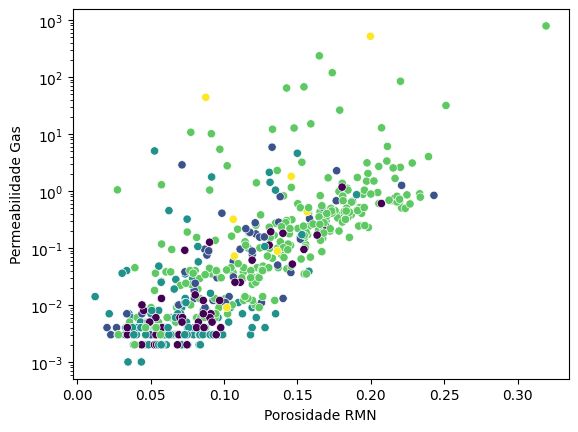

In [ ]:
sns.scatterplot(dados, x='Porosidade RMN', y = 'Permeabilidade Gas', c=np.array(dados['Categoria Litofacies']))
plt.yscale('log')

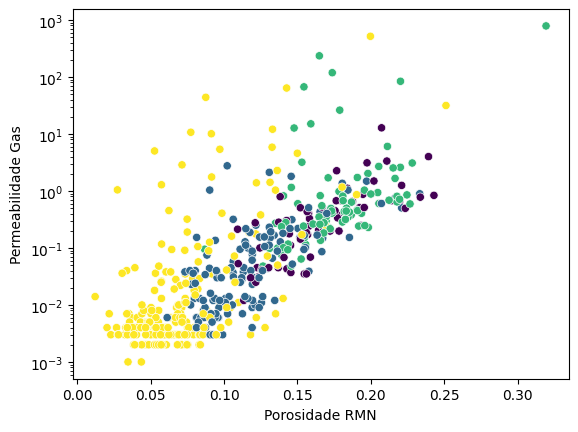

In [ ]:
sns.scatterplot(dados, x='Porosidade RMN', y='Permeabilidade Gas', c=kmeans.labels_, legend = kmeans.labels_.tolist())
plt.yscale('log')

## Método StratifiedShuffleSplit

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, train_size=.7, random_state=9)

X = dados.drop('Categoria Litofacies', axis = 1)
groups = dados['Categoria Litofacies']

for i, (train_index, test_index) in enumerate(sss.split(X, groups)):
  print(f"Fold {i}:")

dados_treino = dados.iloc[train_index]
dados_teste = dados.iloc[test_index]

print(dados_treino['Permeabilidade Gas'].nlargest(10), '\n\n')
print(dados_teste['Permeabilidade Gas'].nlargest(10), '\n\n', len(dados_teste), len(dados_treino))

Fold 0:
Fold 1:
170    786.347
28     235.074
257    118.788
147     84.003
299     67.038
501     43.943
215     26.182
6       15.050
216     12.105
442      6.051
Name: Permeabilidade Gas, dtype: float64 


497    517.279
256     63.984
189     31.587
5       12.813
436     12.714
90      10.713
98      10.084
92       5.389
133      4.588
1        4.005
Name: Permeabilidade Gas, dtype: float64 

 153 354


In [ ]:
salvar_treino = salvar + 'Dados_treino_02_07.xlsx'
salvar_teste = salvar + 'Dados_teste_02_07.xlsx'

dados_treino.drop(['Tempo Distribuicao', 'Distribuicao T2', 'Porosidade i'], axis = 1).sort_values(by = 'Amostra').to_excel(salvar_treino)
dados_teste.drop(['Tempo Distribuicao', 'Distribuicao T2', 'Porosidade i'], axis = 1).sort_values(by = 'Amostra').to_excel(salvar_teste)

# Regressões Lineares

In [ ]:
treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Dados_treino_02_07.xlsx').drop('Unnamed: 0', axis = 1)
teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Dados_teste_02_07.xlsx').drop('Unnamed: 0', axis = 1)

treino.head()

Amostra  Poço     Litofacies  Categoria Litofacies  Bioturbiditos  \
0  AA01-A-05  AA01     Grainstone                     3              0   
1  AA01-A-09  AA01     Grainstone                     3              0   
2  AA01-A-13  AA01     Grainstone                     3              0   
3  AA01-A-15  AA01     Grainstone                     3              0   
4  AA01-B-04  AA01  Dolowackstone                     2              0   

   Dolowackstone  Grainstone  Brechado  Packstone  Porosidade Gas  ...  \
0              0           1         0          0         0.18920  ...   
1              0           1         0          0         0.08149  ...   
2              0           1         0          0         0.18285  ...   
3              0           1         0          0         0.14349  ...   
4              1           0         0          0         0.09433  ...   

   T2 5206.375  T2 5804.697  T2 6471.778  T2 7215.521  T2 8044.736  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   T2 8969.245  T2 10000        A1        A2        A3  
0          0.0       0.0  0.030625  1.093171  0.023777  
1          0.0       0.0  0.008218  0.566483  0.000001  
2          0.0       0.0  0.000001  0.506208  0.000001  
3          0.0       0.0  0.026322  0.970076  0.019740  
4          0.0       0.0  0.610761  0.000349  0.000001  

[5 rows x 155 columns]

In [ ]:
reg_SDR, coef_SDR, df_SDR, erro_SDR = RegressaoSDR(treino)
reg_SDR_teste, coef_SDR_teste, df_SDR_teste, erro_SDR_teste = RegressaoSDR(teste)

t2_teste = df_SDR_teste['T2 Ponderado Log']
phi_teste = df_SDR_teste['Porosidade RMN']

a = coef_SDR['Valor']['a']
b = coef_SDR['Valor']['b']
c = coef_SDR['Valor']['c']
k = (a*(phi_teste**b)*(t2_teste**c))

#Erro Sigma
k_p = np.log10(k)
k_g = np.log10(df_SDR_teste['Permeabilidade Gas'])
N = len(k_p)
soma = np.sum((k_p-k_g)**2)
raiz = np.sqrt(soma/N)
sigma_sdr = 10**(raiz)

print(sigma_sdr)


treino['Permeabilidade Prevista SDR'] = df_SDR['Permeabilidade Prevista']
teste['Permeabilidade Prevista SDR'] = df_SDR_teste['Permeabilidade Prevista']

5.930789175553232


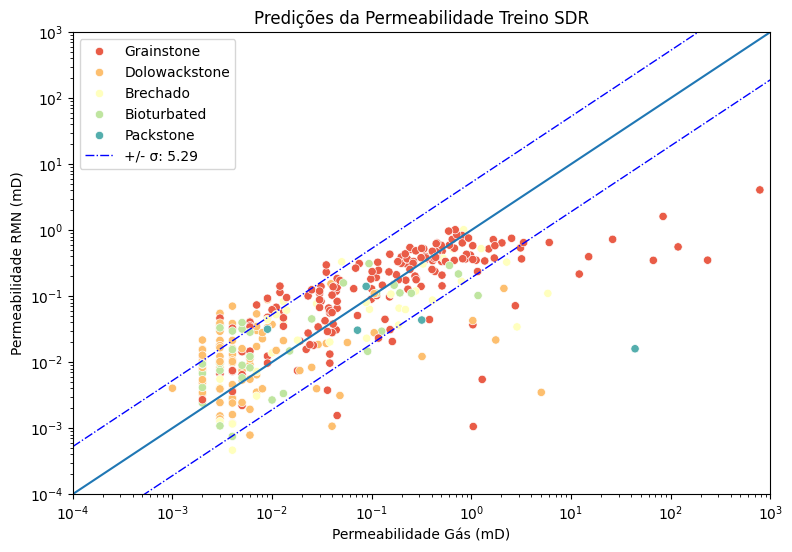

In [ ]:
VisualizarPredicoes(df_SDR, Sigma = True, Valor_Sigma = erro_SDR, Litofacies = 'Litofacies', Modelo = 'Treino SDR')

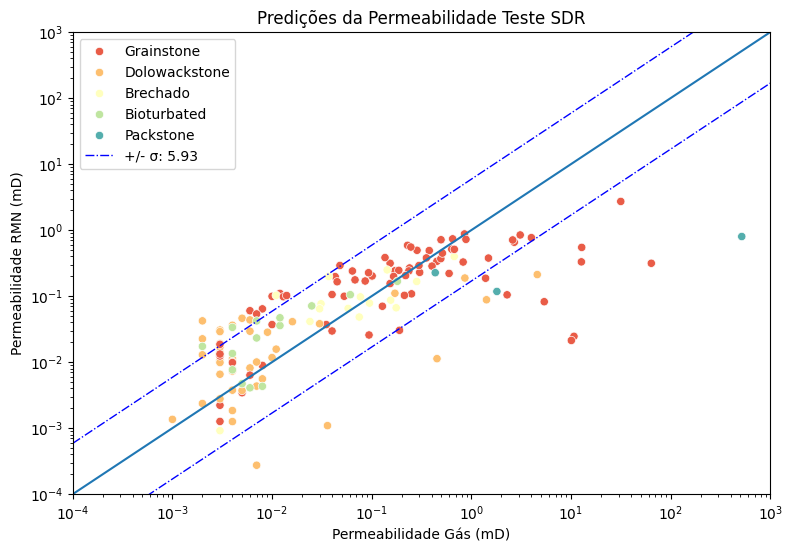

In [ ]:
VisualizarPredicoes(df_SDR_teste, Sigma = True, Valor_Sigma = sigma_sdr, Litofacies = 'Litofacies', Modelo = 'Teste SDR')

In [ ]:
reg_Han, coef_Han, df_Han, erro_Han = RegressaoHan(treino)
reg_Han_teste, coef_Han_teste, df_Han_teste, erro_Han_teste = RegressaoHan(teste)

a = coef_Han['Valor']['a']
b = coef_Han['Valor']['b']
c = coef_Han['Valor']['c']
d = coef_Han['Valor']['d']
e = coef_Han['Valor']['e']
f = coef_Han['Valor']['f']
phi = df_Han_teste['Porosidade RMN']
s1 = df_Han_teste['S1Han']
s2 = df_Han_teste['S2Han']
s3 = df_Han_teste['S3Han']
s4 = df_Han_teste['S4Han']
k = a*(phi**b)*(s3**c)*(s4**d)/((s1**e)*(s2**f))
df_Han_teste['Permeabilidade Prevista'] = k

#Erro Sigma
k_p = np.log10(k)
k_g = np.log10(df_Han_teste['Permeabilidade Gas'])
N = len(k_p)
soma = np.sum((k_p-k_g)**2)
raiz = np.sqrt(soma/N)
sigma_han = 10**(raiz)
print(sigma_han)

treino['Permeabilidade Prevista Han'] = df_Han['Permeabilidade Prevista']
teste['Permeabilidade Prevista Han'] = df_Han_teste['Permeabilidade Prevista']

5.239719236627812


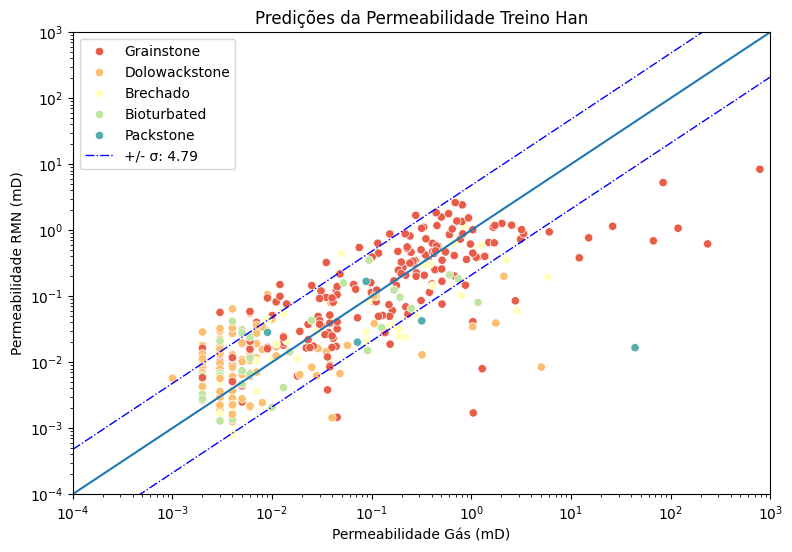

In [ ]:
VisualizarPredicoes(df_Han, Sigma = True, Valor_Sigma = erro_Han, Litofacies = 'Litofacies', Modelo = 'Treino Han')

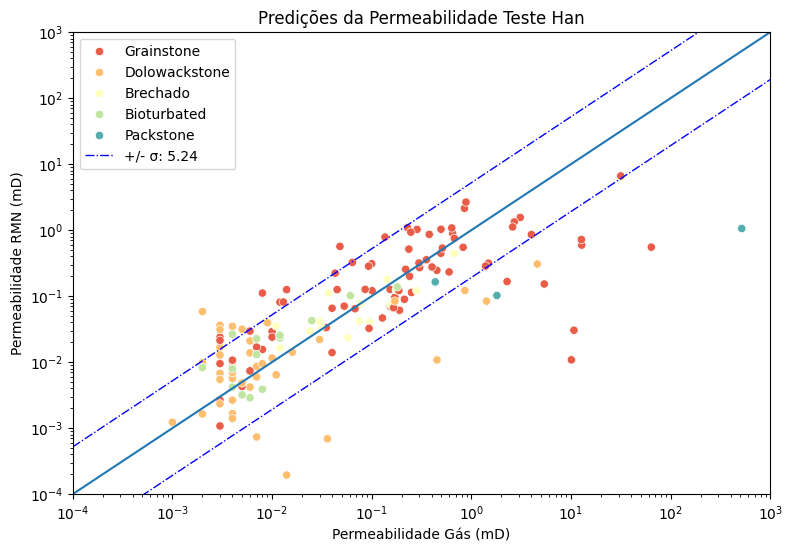

In [ ]:
VisualizarPredicoes(df_Han_teste, Sigma = True, Valor_Sigma = sigma_han, Litofacies = 'Litofacies', Modelo = 'Teste Han')

In [ ]:
reg_Ge, coef_Ge, df_Ge, erro_Ge = RegressaoGe(treino)
reg_Ge_teste, coef_Ge_teste, df_Ge_teste, erro_Ge_teste = RegressaoHan(teste)

a = coef_Ge['Valor']['a']
b = coef_Ge['Valor']['b']
c = coef_Ge['Valor']['c']
d = coef_Ge['Valor']['d']
e = coef_Ge['Valor']['e']
phi = df_Ge_teste['Porosidade RMN']
s1Ge = df_Ge_teste['S1Ge']
s3Ge = df_Ge_teste['S3Ge']
s4Ge = df_Ge_teste['S4Ge']
k = a*(phi**b)*((s3Ge**c)+(s4Ge**d)/(s1Ge**e))
df_Ge_teste['Permeabilidade Prevista'] = k

#Erro Sigma
k_p = np.log10(k)
k_g = np.log10(df_Ge_teste['Permeabilidade Gas'])
N = len(k_p)
soma = np.sum((k_p-k_g)**2)
raiz = np.sqrt(soma/N)
sigma_Ge = 10**(raiz)
print(sigma_Ge)

treino['Permeabilidade Prevista Ge'] = df_Ge['Permeabilidade Prevista']
teste['Permeabilidade Prevista Ge'] = df_Ge_teste['Permeabilidade Prevista']

7.025169509551185


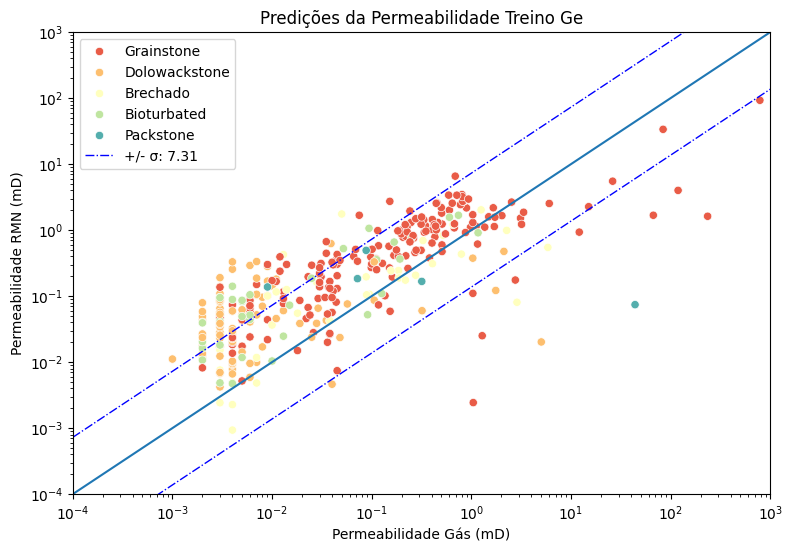

In [ ]:
VisualizarPredicoes(df_Ge, Sigma = True, Valor_Sigma = erro_Ge, Litofacies = 'Litofacies', Modelo = 'Treino Ge')

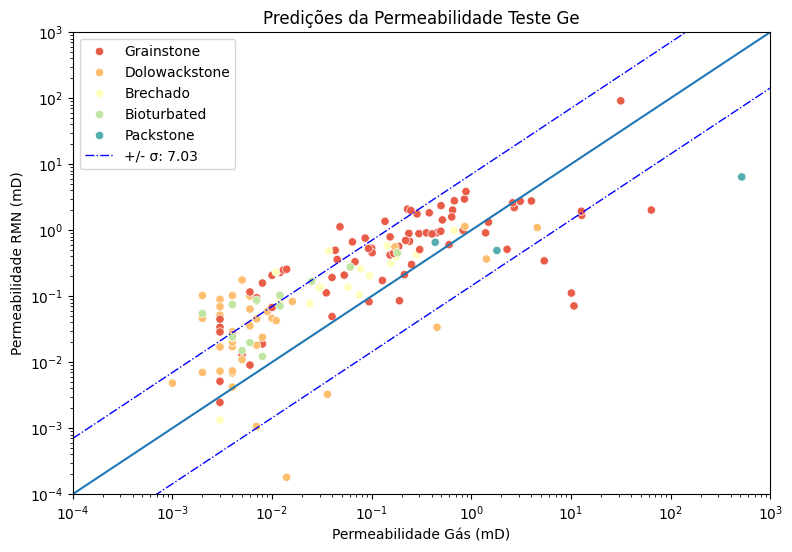

In [ ]:
VisualizarPredicoes(df_Ge_teste, Sigma = True, Valor_Sigma = sigma_Ge, Litofacies = 'Litofacies', Modelo = 'Teste Ge')

In [ ]:
reg_Coates, coef_Coates, df_Coates, erro_Coates = RegressaoCoates(treino)
reg_Coates_teste, coef_Coates_teste, df_Coates_teste, erro_Coates_teste = RegressaoCoates(teste)

a = coef_Coates['Valor']['a']
b = coef_Coates['Valor']['b']
c = coef_Coates['Valor']['c']
phi = df_Coates_teste['Porosidade RMN']
ffibvi = df_Coates_teste['FFI']/df_Coates_teste['BVI']

k = a*(phi**b)*(ffibvi**c)
df_Coates_teste['Permeabilidade Prevista'] = k

#Erro Sigma
k_p = np.log10(k)
k_g = np.log10(df_Coates_teste['Permeabilidade Gas'])
N = len(k_p)
soma = np.sum((k_p-k_g)**2)
raiz = np.sqrt(soma/N)
sigma_Coates = 10**(raiz)
print(sigma_Coates)

treino['Permeabilidade Prevista Coates'] = df_Coates['Permeabilidade Prevista']
teste['Permeabilidade Prevista Coates'] = df_Coates_teste['Permeabilidade Prevista']

5.656739807238246


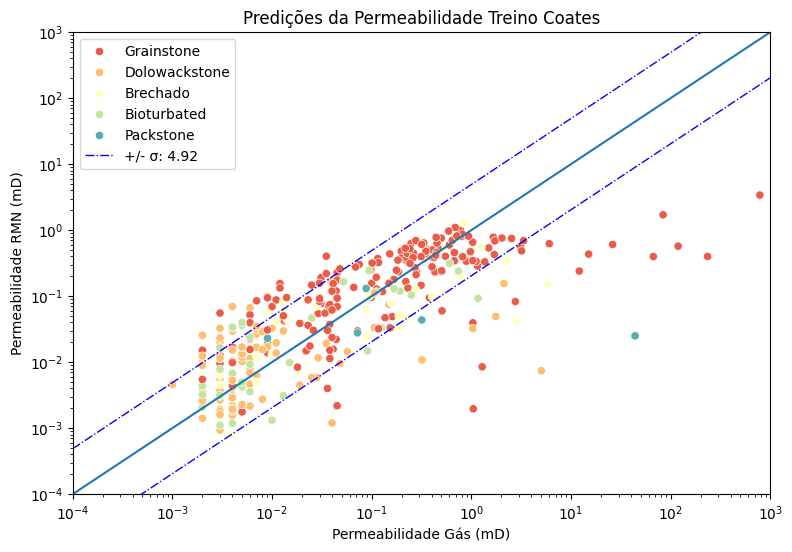

In [ ]:
VisualizarPredicoes(df_Coates, Sigma = True, Valor_Sigma = erro_Coates, Litofacies = 'Litofacies', Modelo = 'Treino Coates')

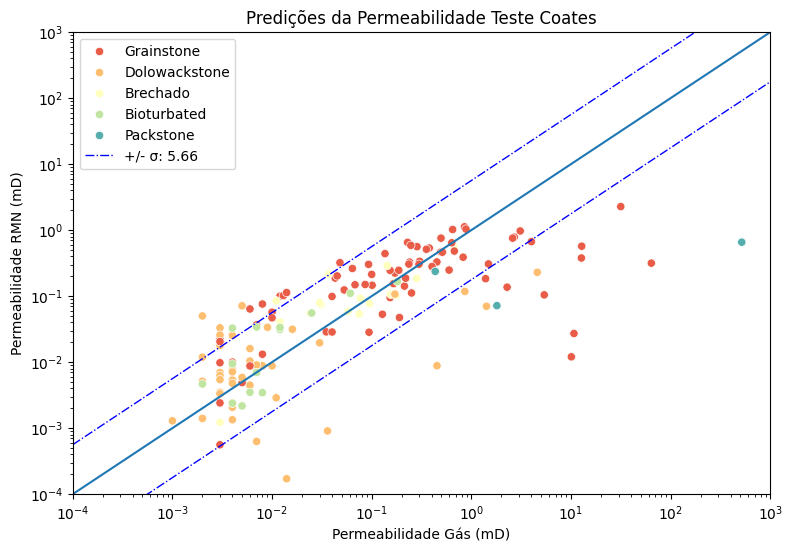

In [ ]:
VisualizarPredicoes(df_Coates_teste, Sigma = True, Valor_Sigma = sigma_Coates, Litofacies = 'Litofacies', Modelo = 'Teste Coates')

In [ ]:
previsao_treino, previsao_teste = regressao_Rios(treino, teste)

# Avaliando dados

In [ ]:
salvar_predicoes_treino = salvar + 'Dados_previstos_treino_02_07.xlsx'
salvar_predicoes_teste = salvar + 'Dados_previstos_teste_02_07.xlsx'

#previsao_treino.sort_values(by = 'Amostra').to_excel(salvar_predicoes_treino)
#previsao_teste.sort_values(by = 'Amostra').to_excel(salvar_predicoes_teste)

# Avaliação Reservatório

## Abertura dos dados

In [ ]:
previsao_treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Previsao_Treino.xlsx').drop('Unnamed: 0', axis = 1)
previsao_teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Previsao_Teste.xlsx').drop('Unnamed: 0', axis = 1)

ktr = previsao_treino['Permeabilidade Prevista MLP']
kte = previsao_teste['Permeabilidade Prevista MLP']

previsao_treino['Permeabilidade Prevista MLP'] = (10**ktr)/1000
previsao_teste['Permeabilidade Prevista MLP'] = (10**kte)/1000

k_gtr = previsao_treino['Permeabilidade Gas']
k_gte = previsao_treino['Permeabilidade Gas']

previsao_treino['Permeabilidade Prevista Gas'] = k_gtr
previsao_teste['Permeabilidade Prevista Gas'] = k_gte

In [ ]:
reservatorio_treino = AvaliacaoReservatorio(previsao_treino, Modelagens = ['SDR', 'Han', 'Ge', 'Coates', 'Rios', 'MLP', 'Gas'])
reservatorio_teste = AvaliacaoReservatorio(previsao_teste, Modelagens = ['SDR', 'Han', 'Ge', 'Coates', 'Rios', 'MLP', 'Gas'])

#salvar = '/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/'
#salvar_reservatorio_treino = salvar + 'Reservatórios_Treino.xlsx'
#salvar_reservatorio_teste = salvar + 'Reservatórios_Teste.xlsx'

#salvar_coef_teste = salvar + 'Coef_Teste.xlsx'
#salvar_coef_treino = salvar + 'Coef_Treino.xlsx'

#reservatorio_treino.to_excel(salvar_reservatorio_treino)
#reservatorio_teste.to_excel(salvar_reservatorio_teste)

## Separação por HFU

In [ ]:
#treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Reservatórios_Treino.xlsx').drop('Unnamed: 0', axis = 1)
#teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Reservatórios_Teste.xlsx').drop('Unnamed: 0', axis = 1)
#df_treino, df_teste, coef_treino, coef_teste = ObtencaoFZI(treino, teste, modelos = ['SDR', 'Han', 'Coates', 'Rios', 'MLP'])

In [ ]:
df_treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Polar_Treino.xlsx').drop('Unnamed: 0', axis = 1)
df_teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Polar_Teste.xlsx').drop('Unnamed: 0', axis = 1)
coef_treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Coef_FZI_Treino.xlsx').drop('Unnamed: 0', axis = 1)
coef_teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/Coef_FZI_Teste.xlsx').drop('Unnamed: 0', axis = 1)

### Visualizar Conjunto de Permeabilidade

In [ ]:
def VisualizarPredicoes2 (Dados, Pasta_Salvamento = None, Data= None, Modelo = None,
                          Litofacies = None, Sigma = False):

    if str(Modelo[:7]) == 'Treino ':
      previsao = 'Permeabilidade Prevista ' + str(Modelo[7:])
    else:
      previsao = 'Permeabilidade Prevista ' + str(Modelo[6:])
    eixo_x = 'Gas Permeability (mD)'
    eixo_y = 'NMR Permeability (mD)'
    reta = pd.DataFrame({'x' : np.arange(100000),
                         'y' : np.arange(100000)})
    sns.scatterplot(data = Dados,
                    x = 'Permeabilidade Gas',
                    y = previsao,
                    hue = Litofacies,
                    palette = 'Set1',
                    s=140)
    sns.lineplot(data = reta,
                 x = 'x',
                 y = 'y')
    if Sigma == True:
        k_p = np.log10(Dados[previsao])
        k_g = np.log10(Dados['Permeabilidade Gas'])
        N = len(k_p)
        soma = np.sum((k_p-k_g)**2)
        raiz = np.sqrt(soma/N)
        Valor_Sigma = 10**(raiz)
        plt.plot(reta['x'], reta['y'] * Valor_Sigma, "b-.", linewidth=1)
        plt.plot(reta['x'], reta['y'] / Valor_Sigma, "b-.", linewidth=1, label = f'+/- \u03C3: {Valor_Sigma:.2f}')

    plt.xlabel(eixo_x, fontsize=16)
    plt.ylabel(eixo_y, fontsize=16)
    plt.xlim(0.0001,100000)
    plt.ylim(0.0001,100000)
    plt.text(10, 9000, 'Model ' + previsao[24:])
    plt.legend(loc="upper left", fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.tick_params(axis='both', labelsize=16)
    plt.xticks([0.0001, 0.01, 1, 100, 10000])
    plt.yticks([0.0001, 0.01, 1, 100, 10000])

def VisualizarPoroPer(Dados):

    eixo_x = 'Gas Porosity'
    eixo_y = 'Gas Permeability (mD)'
    sns.scatterplot(data = Dados,
                    x = 'Porosidade Gas',
                    y = 'Permeabilidade Gas',
                    hue = 'FZI_Cluster',
                    palette = 'Set1',
                    s=140)

    plt.xlabel(eixo_x, fontsize=16)
    plt.ylabel(eixo_y, fontsize=16)
    plt.ylim(0.0001,100000)
    plt.xlim(0, 0.35)
    plt.legend(loc="upper left", fontsize=16)
    plt.yscale('log')
    plt.tick_params(axis='both', labelsize=16)
    plt.xticks([0.07, 0.14, 0.21, 0.28, 0.35])
    plt.yticks([0.0001, 0.01, 1, 100, 10000])

Text(1000, 0.001, 'F)')

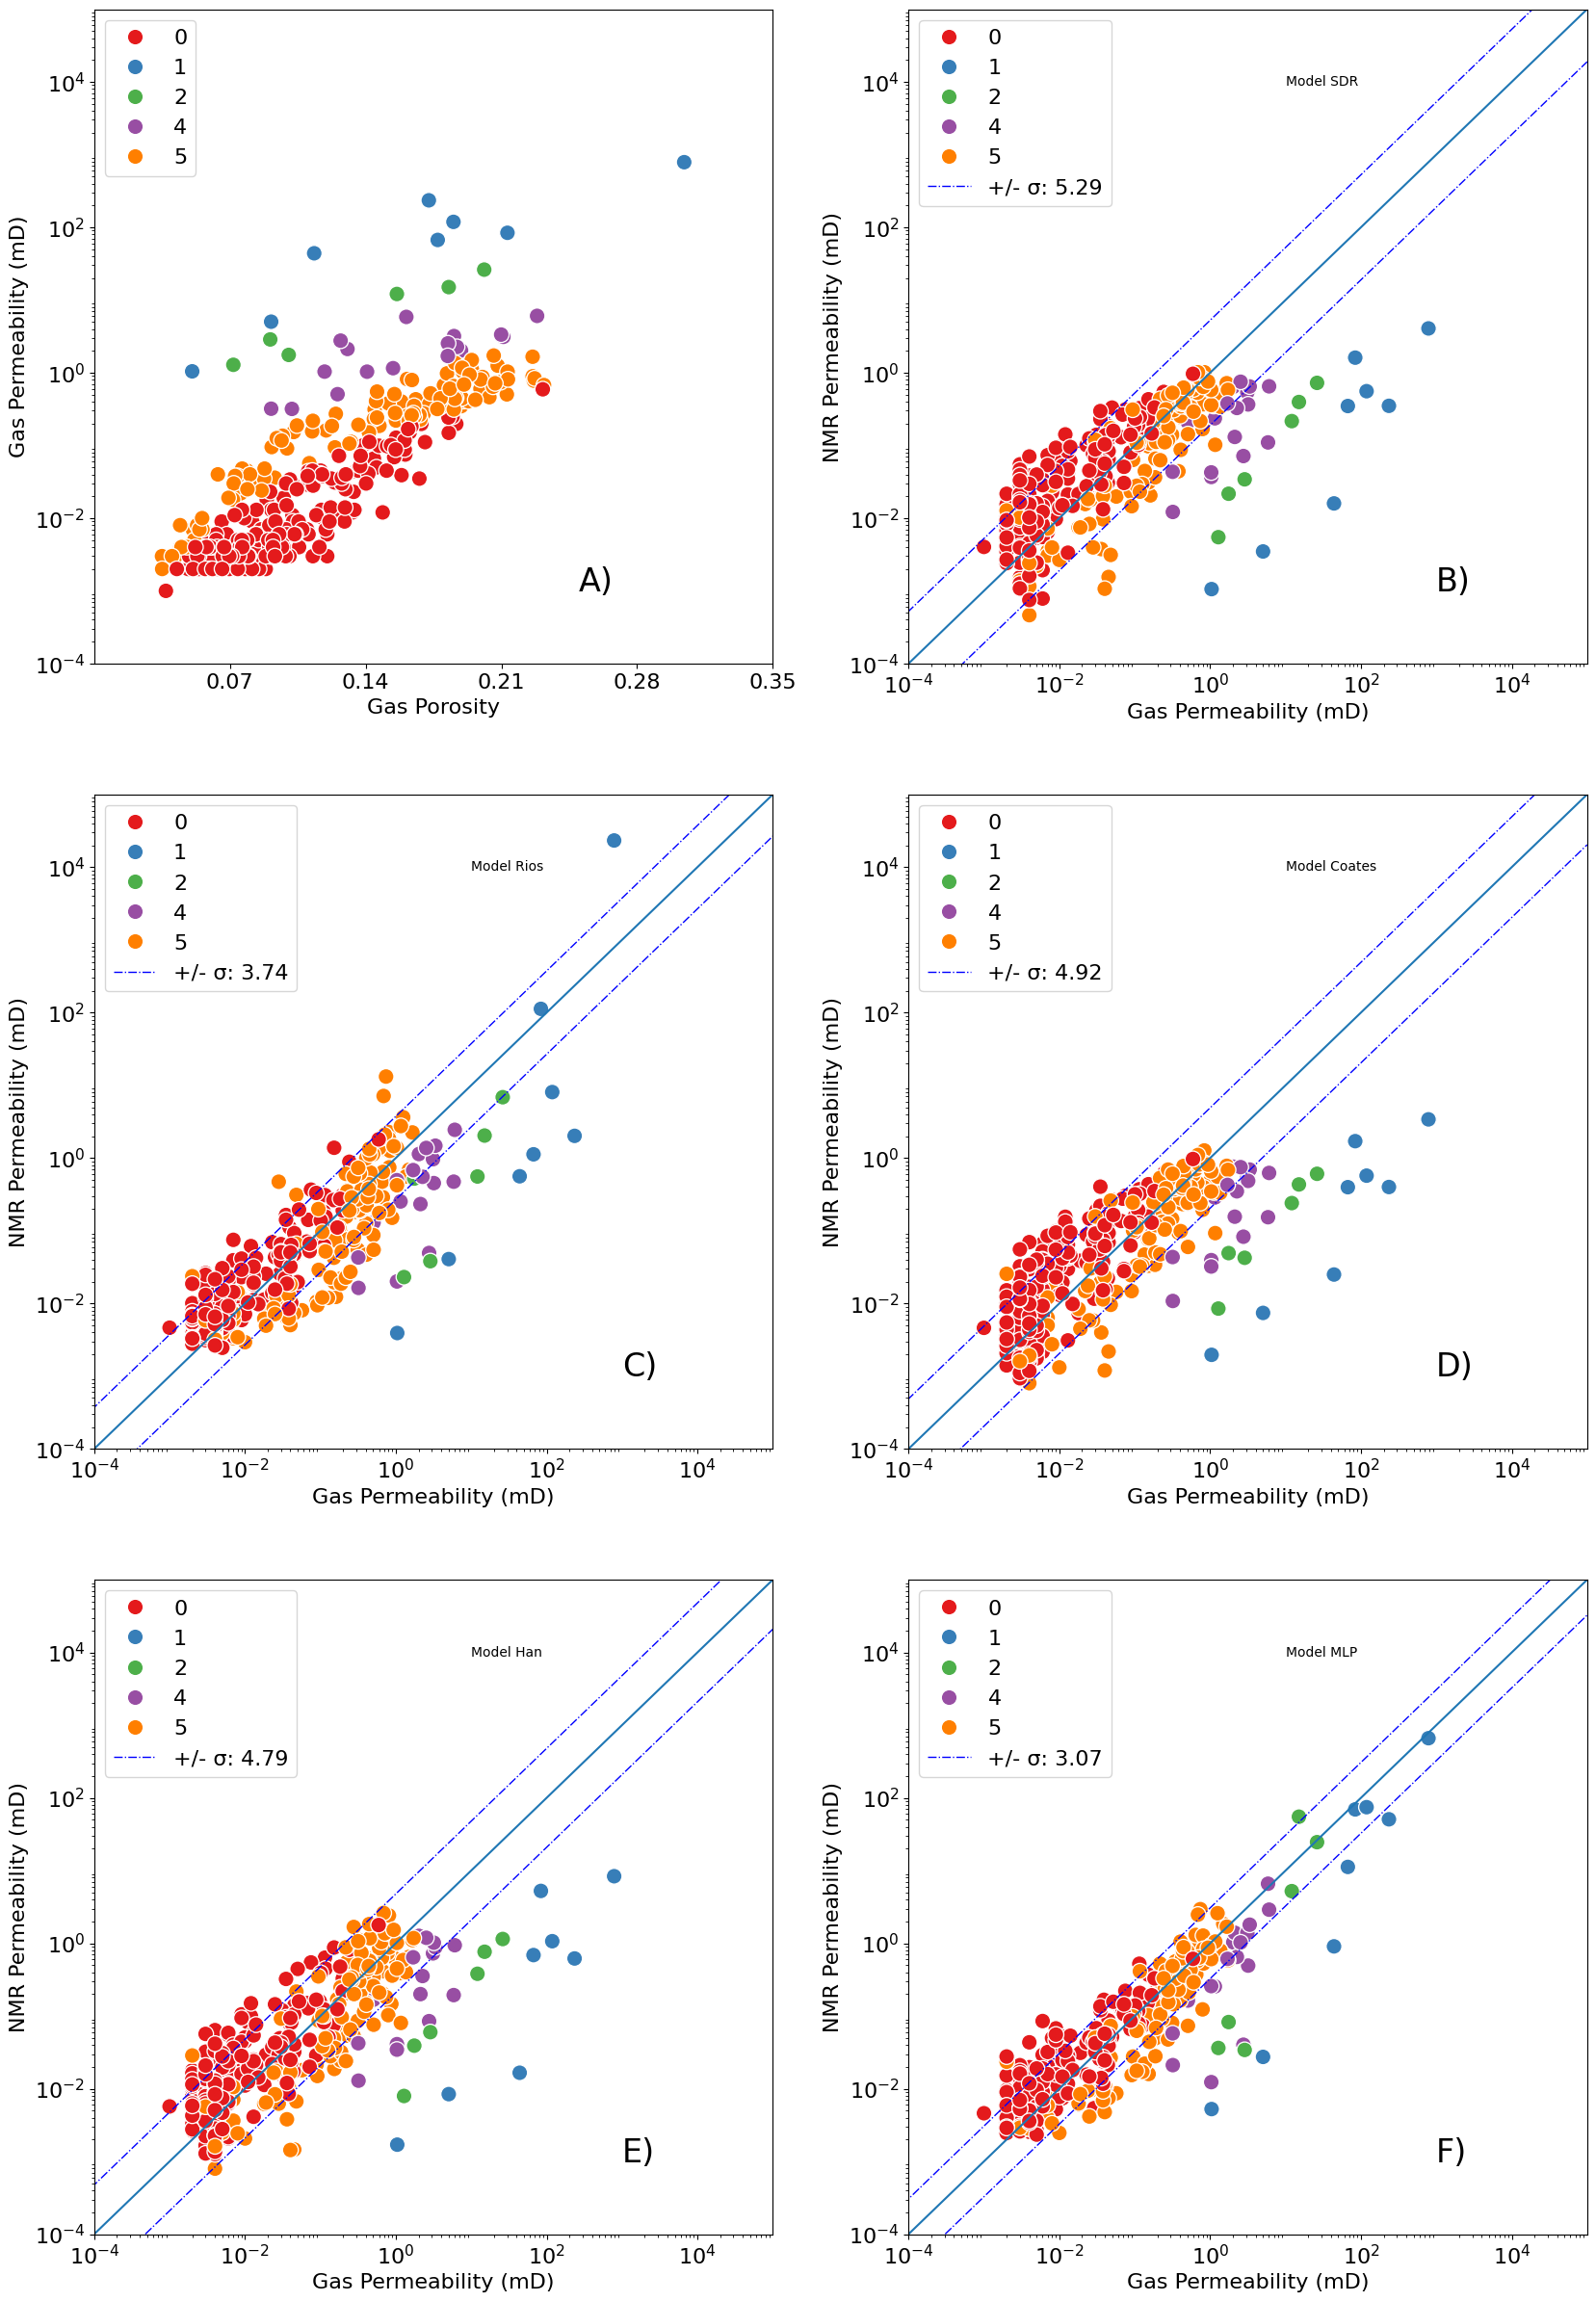

In [ ]:
fig = plt.figure(figsize = (20,30))

ax1 = fig.add_subplot(321)
VisualizarPoroPer(df_treino)
ax1.text(0.25, 0.001, 'A)', fontsize = 24)

ax2 = fig.add_subplot(322)
VisualizarPredicoes2(df_treino, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino SDR')
ax2.text(1000, 0.001, 'B)', fontsize = 24)

ax3 = fig.add_subplot(323)
VisualizarPredicoes2(df_treino, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino Rios')
ax3.text(1000, 0.001, 'C)', fontsize = 24)

ax4 = fig.add_subplot(324)
VisualizarPredicoes2(df_treino, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino Coates')
ax4.text(1000, 0.001, 'D)', fontsize = 24)

ax5 = fig.add_subplot(325)
VisualizarPredicoes2(df_treino, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino Han')
ax5.text(1000, 0.001, 'E)', fontsize = 24)

ax6 = fig.add_subplot(326)
VisualizarPredicoes2(df_treino, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino MLP')
ax6.text(1000, 0.001, 'F)', fontsize = 24)

Text(0, 0.5, '')

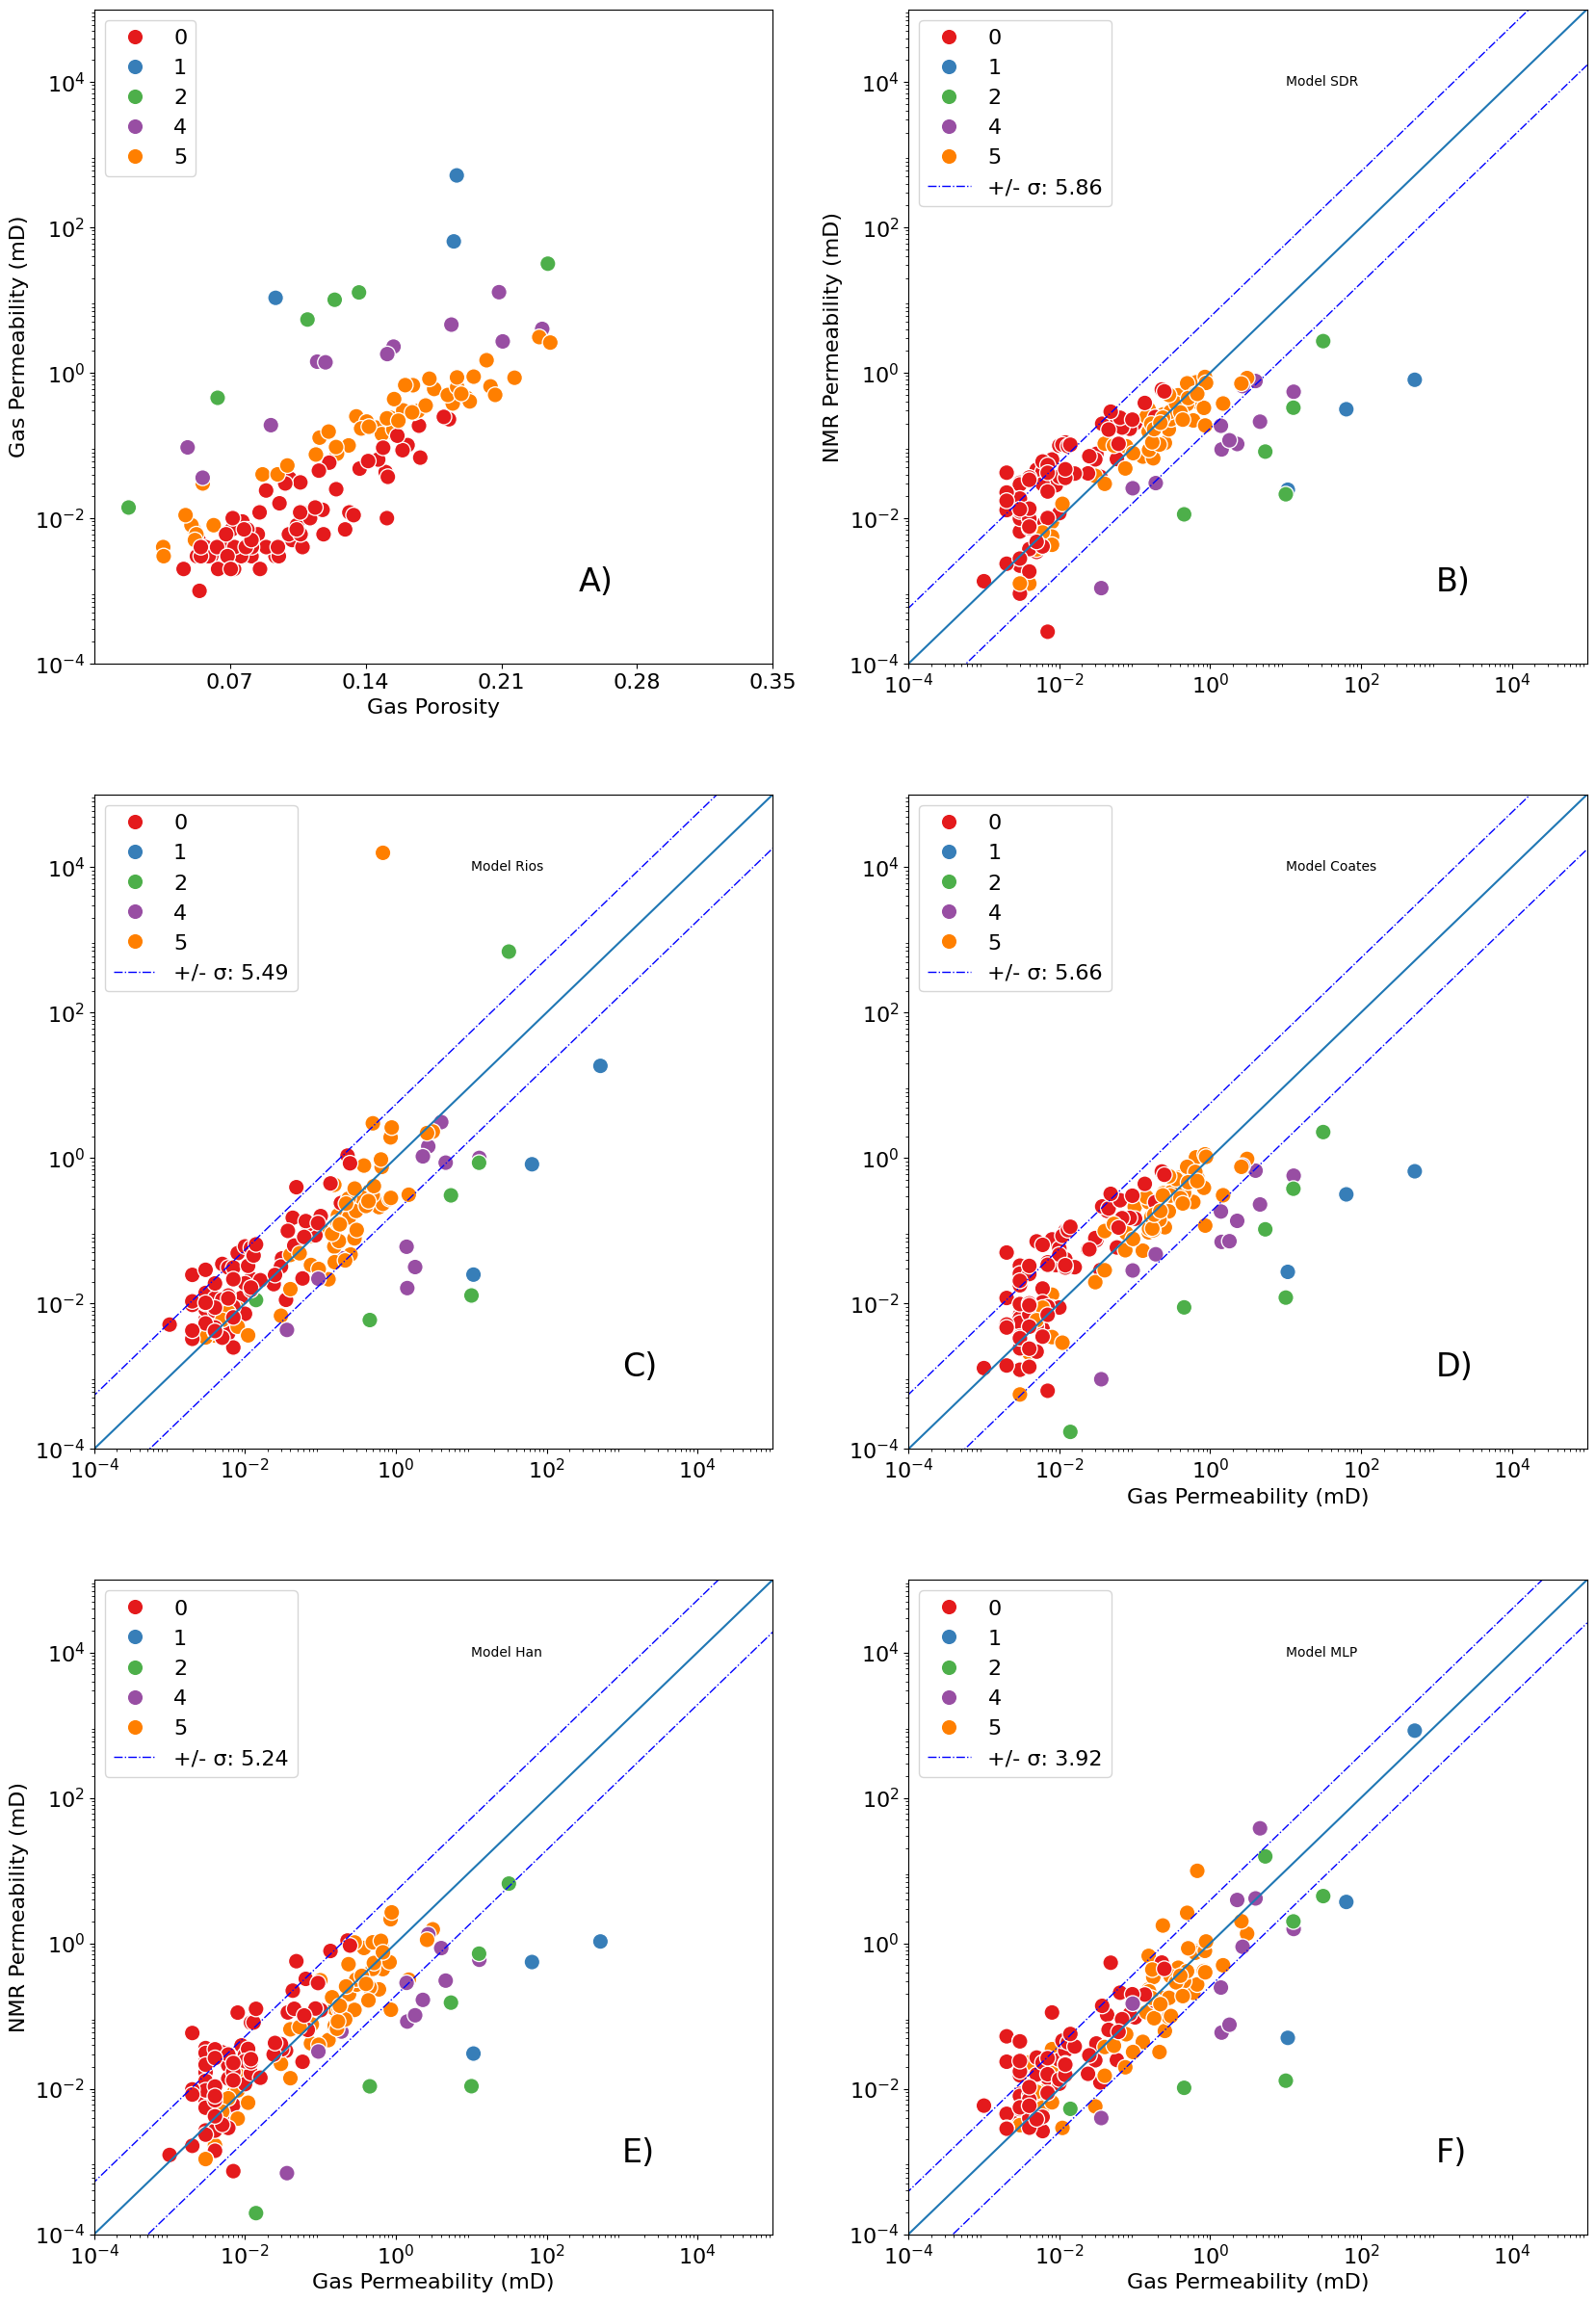

In [ ]:
fig = plt.figure(figsize = (20,30))

ax1 = fig.add_subplot(321)
VisualizarPoroPer(df_teste)
ax1.text(0.25, 0.001, 'A)', fontsize = 24)
ax1

ax2 = fig.add_subplot(322)
VisualizarPredicoes2(df_teste, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino SDR')
ax2.text(1000, 0.001, 'B)', fontsize = 24)
ax2.set_xlabel('')

ax3 = fig.add_subplot(323)
VisualizarPredicoes2(df_teste, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino Rios')
ax3.text(1000, 0.001, 'C)', fontsize = 24)
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4 = fig.add_subplot(324)
VisualizarPredicoes2(df_teste, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino Coates')
ax4.text(1000, 0.001, 'D)', fontsize = 24)
ax4.set_ylabel('')

ax5 = fig.add_subplot(325)
VisualizarPredicoes2(df_teste, Sigma = True, Litofacies = 'FZI_Cluster', Modelo = 'Treino Han')
ax5.text(1000, 0.001, 'E)', fontsize = 24)

ax6 = fig.add_subplot(326)
VisualizarPredicoes2(df_teste, Sigma = True,Litofacies = 'FZI_Cluster', Modelo = 'Treino MLP')
ax6.text(1000, 0.001, 'F)', fontsize = 24)
ax6.set_ylabel('')

### Visualização RQIxPhi_z

In [ ]:
def VisualizarRQI(dados, coef, phi, rqi, modelo='Gas'):
    eixo_x = 'φz'
    eixo_y = 'RQI'

    xis = np.arange(0.001, 1.1, 0.1)

    y_0 = coef['FZI_coef_' + modelo][0] * xis
    y_1 = coef['FZI_coef_' + modelo][1] * xis
    y_2 = coef['FZI_coef_' + modelo][2] * xis
    y_3 = coef['FZI_coef_' + modelo][3] * xis
    y_4 = coef['FZI_coef_' + modelo][4] * xis

    reta = pd.DataFrame({
        'x': xis,
        'y_0': y_0,
        'y_1': y_1,
        'y_2': y_2,
        'y_3': y_3,
        'y_4': y_4
    })

    sns.scatterplot(data=dados, x=phi, y=rqi, hue='FZI_Cluster', palette='Set1', s = 140)
    line_0 = sns.lineplot(data=reta, x='x', y='y_0', color='red')
    line_1 = sns.lineplot(data=reta, x='x', y='y_1', color='blue')
    line_2 = sns.lineplot(data=reta, x='x', y='y_2', color='green')
    line_3 = sns.lineplot(data=reta, x='x', y='y_3', color='purple')
    line_4 = sns.lineplot(data=reta, x='x', y='y_4', color='orange')

    # Adicionando entradas na legenda para os coeficientes
    legend_labels = [
        f"{coef['FZI_coef_' + modelo][0]:.2f}",
        f"{coef['FZI_coef_' + modelo][1]:.2f}",
        f"{coef['FZI_coef_' + modelo][2]:.2f}",
        f"{coef['FZI_coef_' + modelo][3]:.2f}",
        f"{coef['FZI_coef_' + modelo][4]:.2f}"
    ]

    custom_lines = [
        Line2D([0], [0], color='red', lw=2),
        Line2D([0], [0], color='blue', lw=2),
        Line2D([0], [0], color='green', lw=2),
        Line2D([0], [0], color='purple', lw=2),
        Line2D([0], [0], color='orange', lw=2)
    ]

    plt.legend(custom_lines, legend_labels, title="FZI Coefficient", fontsize=16, loc='upper left')

    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    plt.ylim([0.001, 10])
    plt.xlim([0.01, 1])
    plt.tick_params(axis='both', labelsize=16)
    plt.xticks([0.01, 0.05, 0.1, 0.5, 1])
    plt.xscale('log')
    plt.yscale('log')

Text(0, 0.5, '')

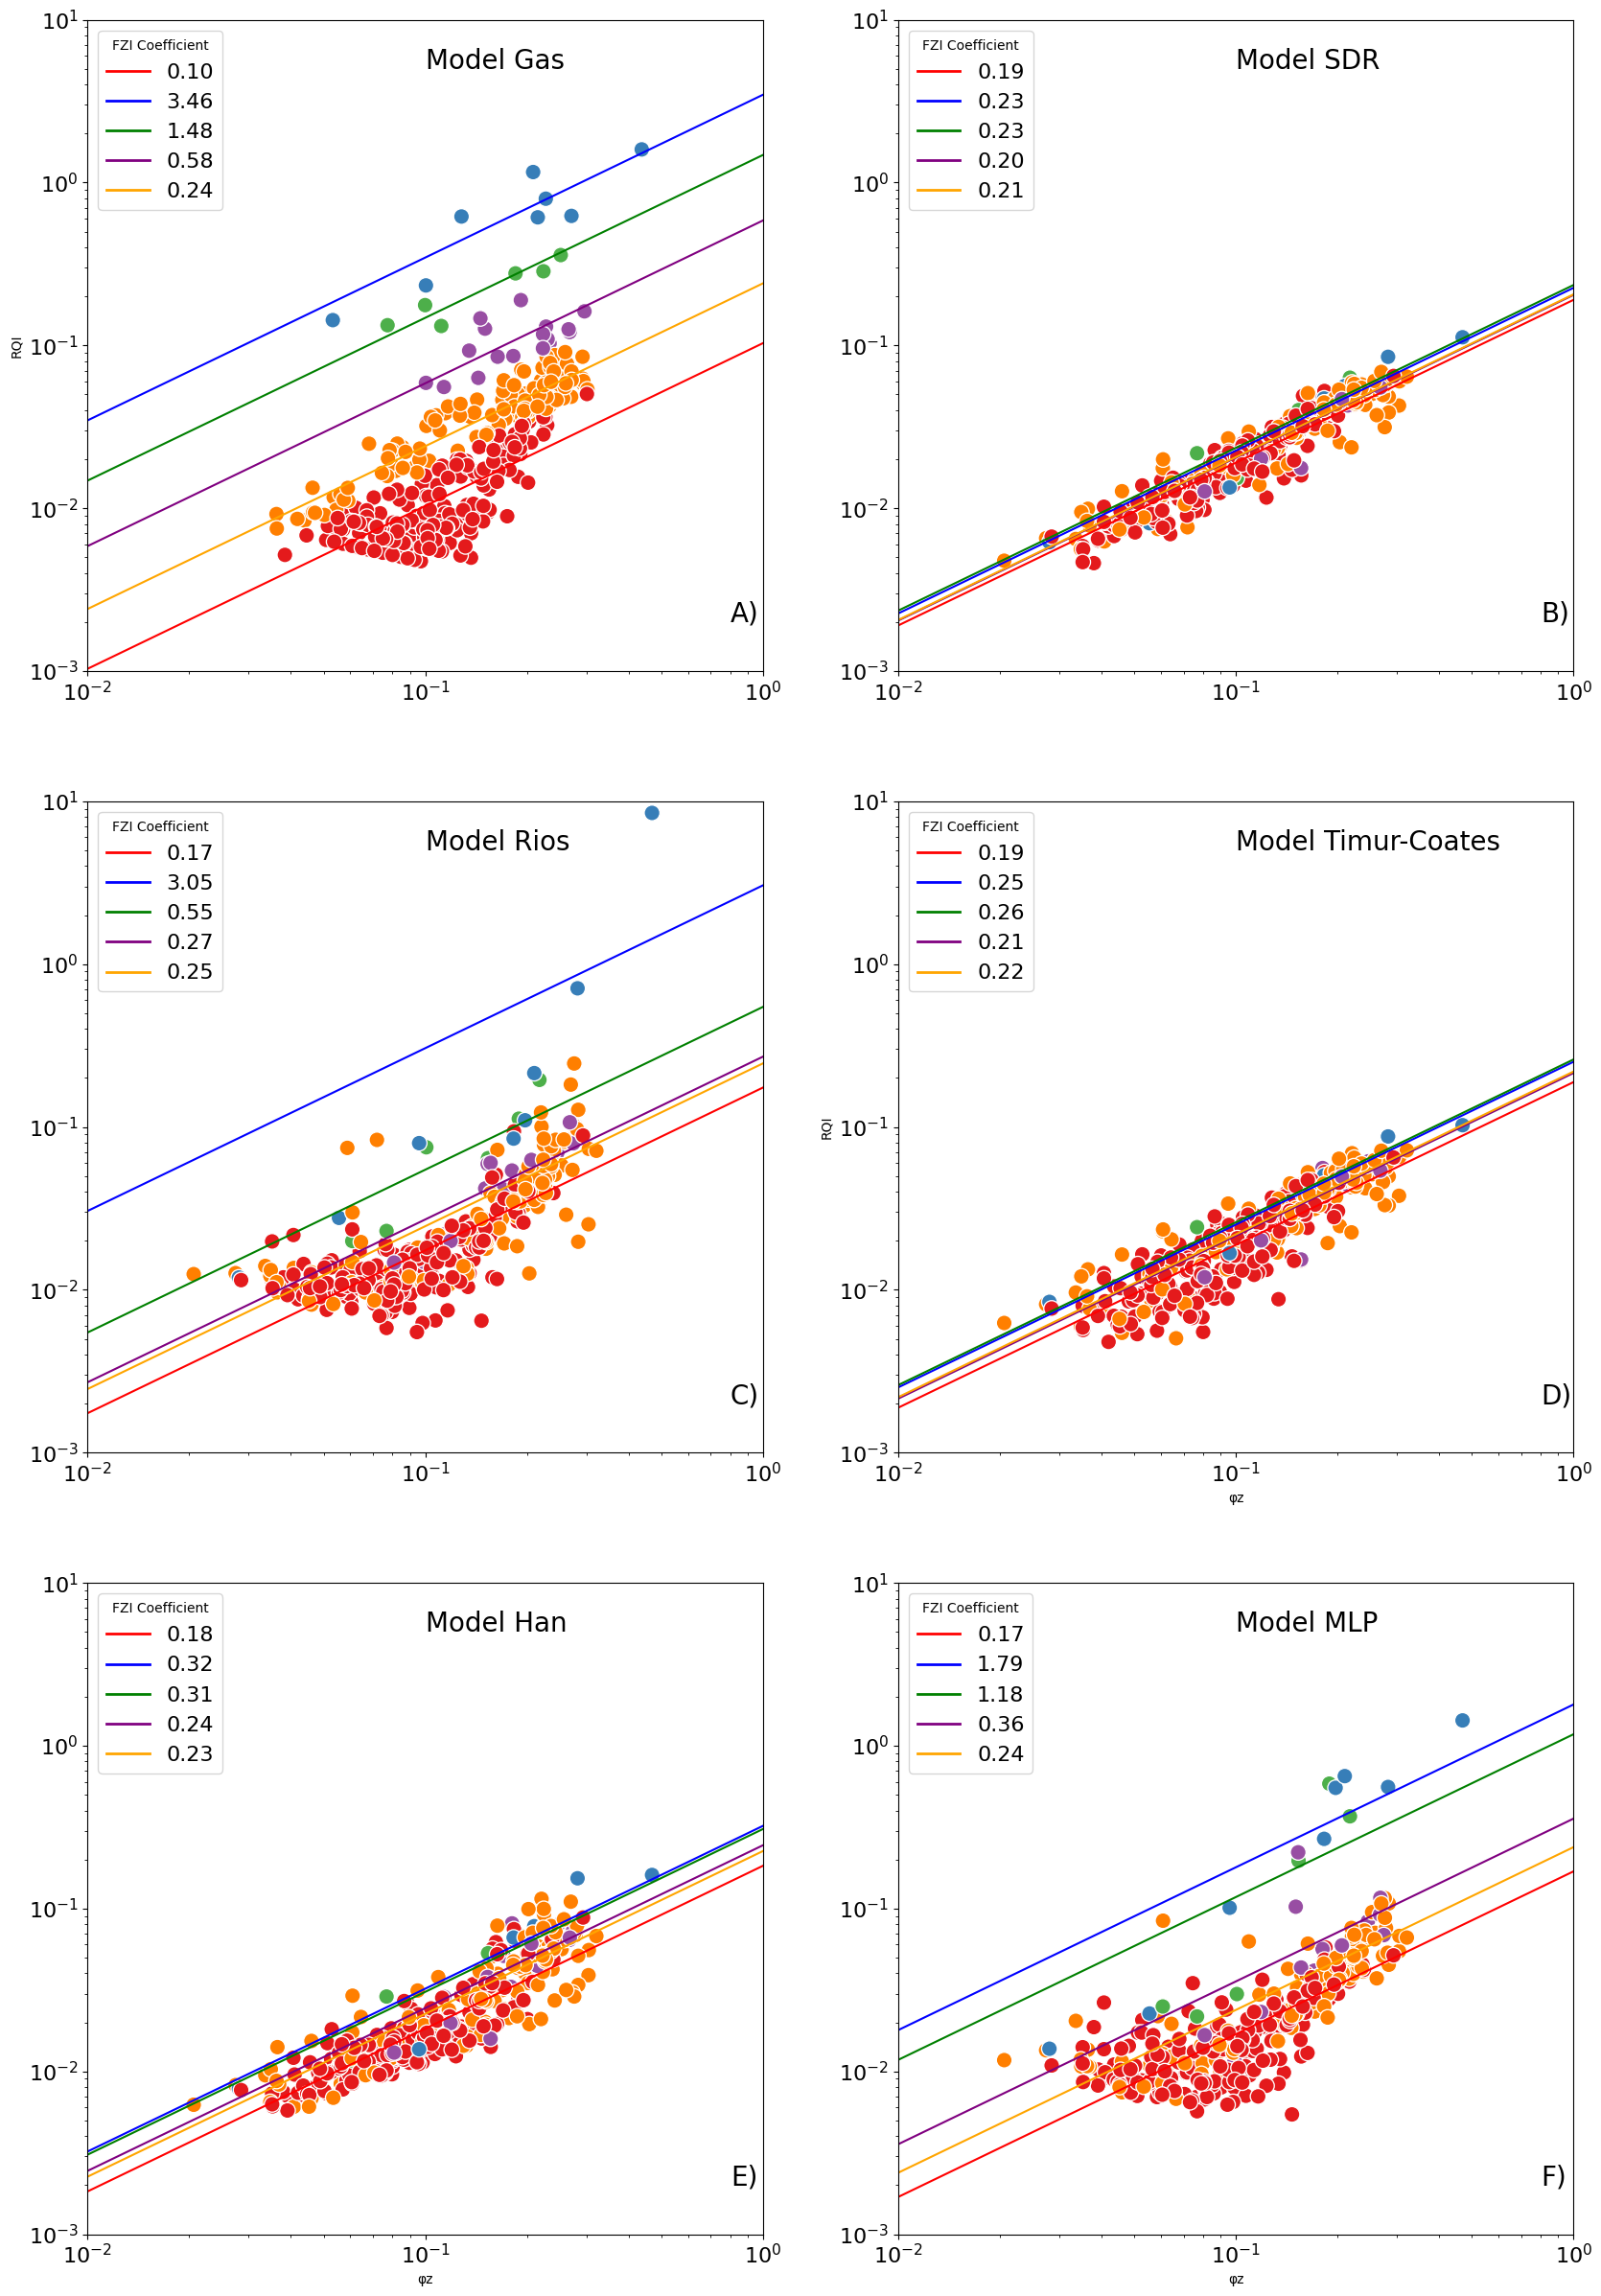

In [ ]:
fig = plt.figure(figsize = (20,30))
ax1 = fig.add_subplot(321)
VisualizarRQI(df_treino, coef_treino, 'Phi_z_Gas', 'RQI_Gas', 'Gas')
ax1.text(0.8, 0.002, 'A)', fontsize = 20)
ax1.text(0.1, 5, "Model Gas", fontsize = 20)
ax1.set_xlabel('')

ax2 = fig.add_subplot(322)
VisualizarRQI(df_treino, coef_treino, 'Phi_z_RMN', 'RQI_SDR', 'SDR')
ax2.text(0.8, 0.002, 'B)', fontsize = 20)
ax2.text(0.1, 5, "Model SDR", fontsize = 20)
ax2.set_xlabel('')
ax2.set_ylabel('')

ax3 = fig.add_subplot(323)
VisualizarRQI(df_treino, coef_treino, 'Phi_z_RMN', 'RQI_Rios', 'Rios')
ax3.text(0.8, 0.002, 'C)', fontsize = 20)
ax3.text(0.1, 5, "Model Rios", fontsize = 20)
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4 = fig.add_subplot(324)
VisualizarRQI(df_treino, coef_treino, 'Phi_z_RMN', 'RQI_Coates', 'Coates')
ax4.text(0.8, 0.002, 'D)', fontsize = 20)
ax4.text(0.1, 5, "Model Timur-Coates", fontsize = 20)

ax5 = fig.add_subplot(325)
VisualizarRQI(df_treino, coef_treino, 'Phi_z_RMN', 'RQI_Han', 'Han')
ax5.text(0.8, 0.002, 'E)', fontsize = 20)
ax5.text(0.1, 5, "Model Han", fontsize = 20)
ax5.set_ylabel('')

ax6 = fig.add_subplot(326)
VisualizarRQI(df_treino, coef_treino, 'Phi_z_RMN', 'RQI_MLP', 'MLP')
ax6.text(0.8, 0.002, 'F)', fontsize = 20)
ax6.text(0.1, 5, "Model MLP", fontsize = 20)
ax6.set_ylabel('')

Text(0, 0.5, '')

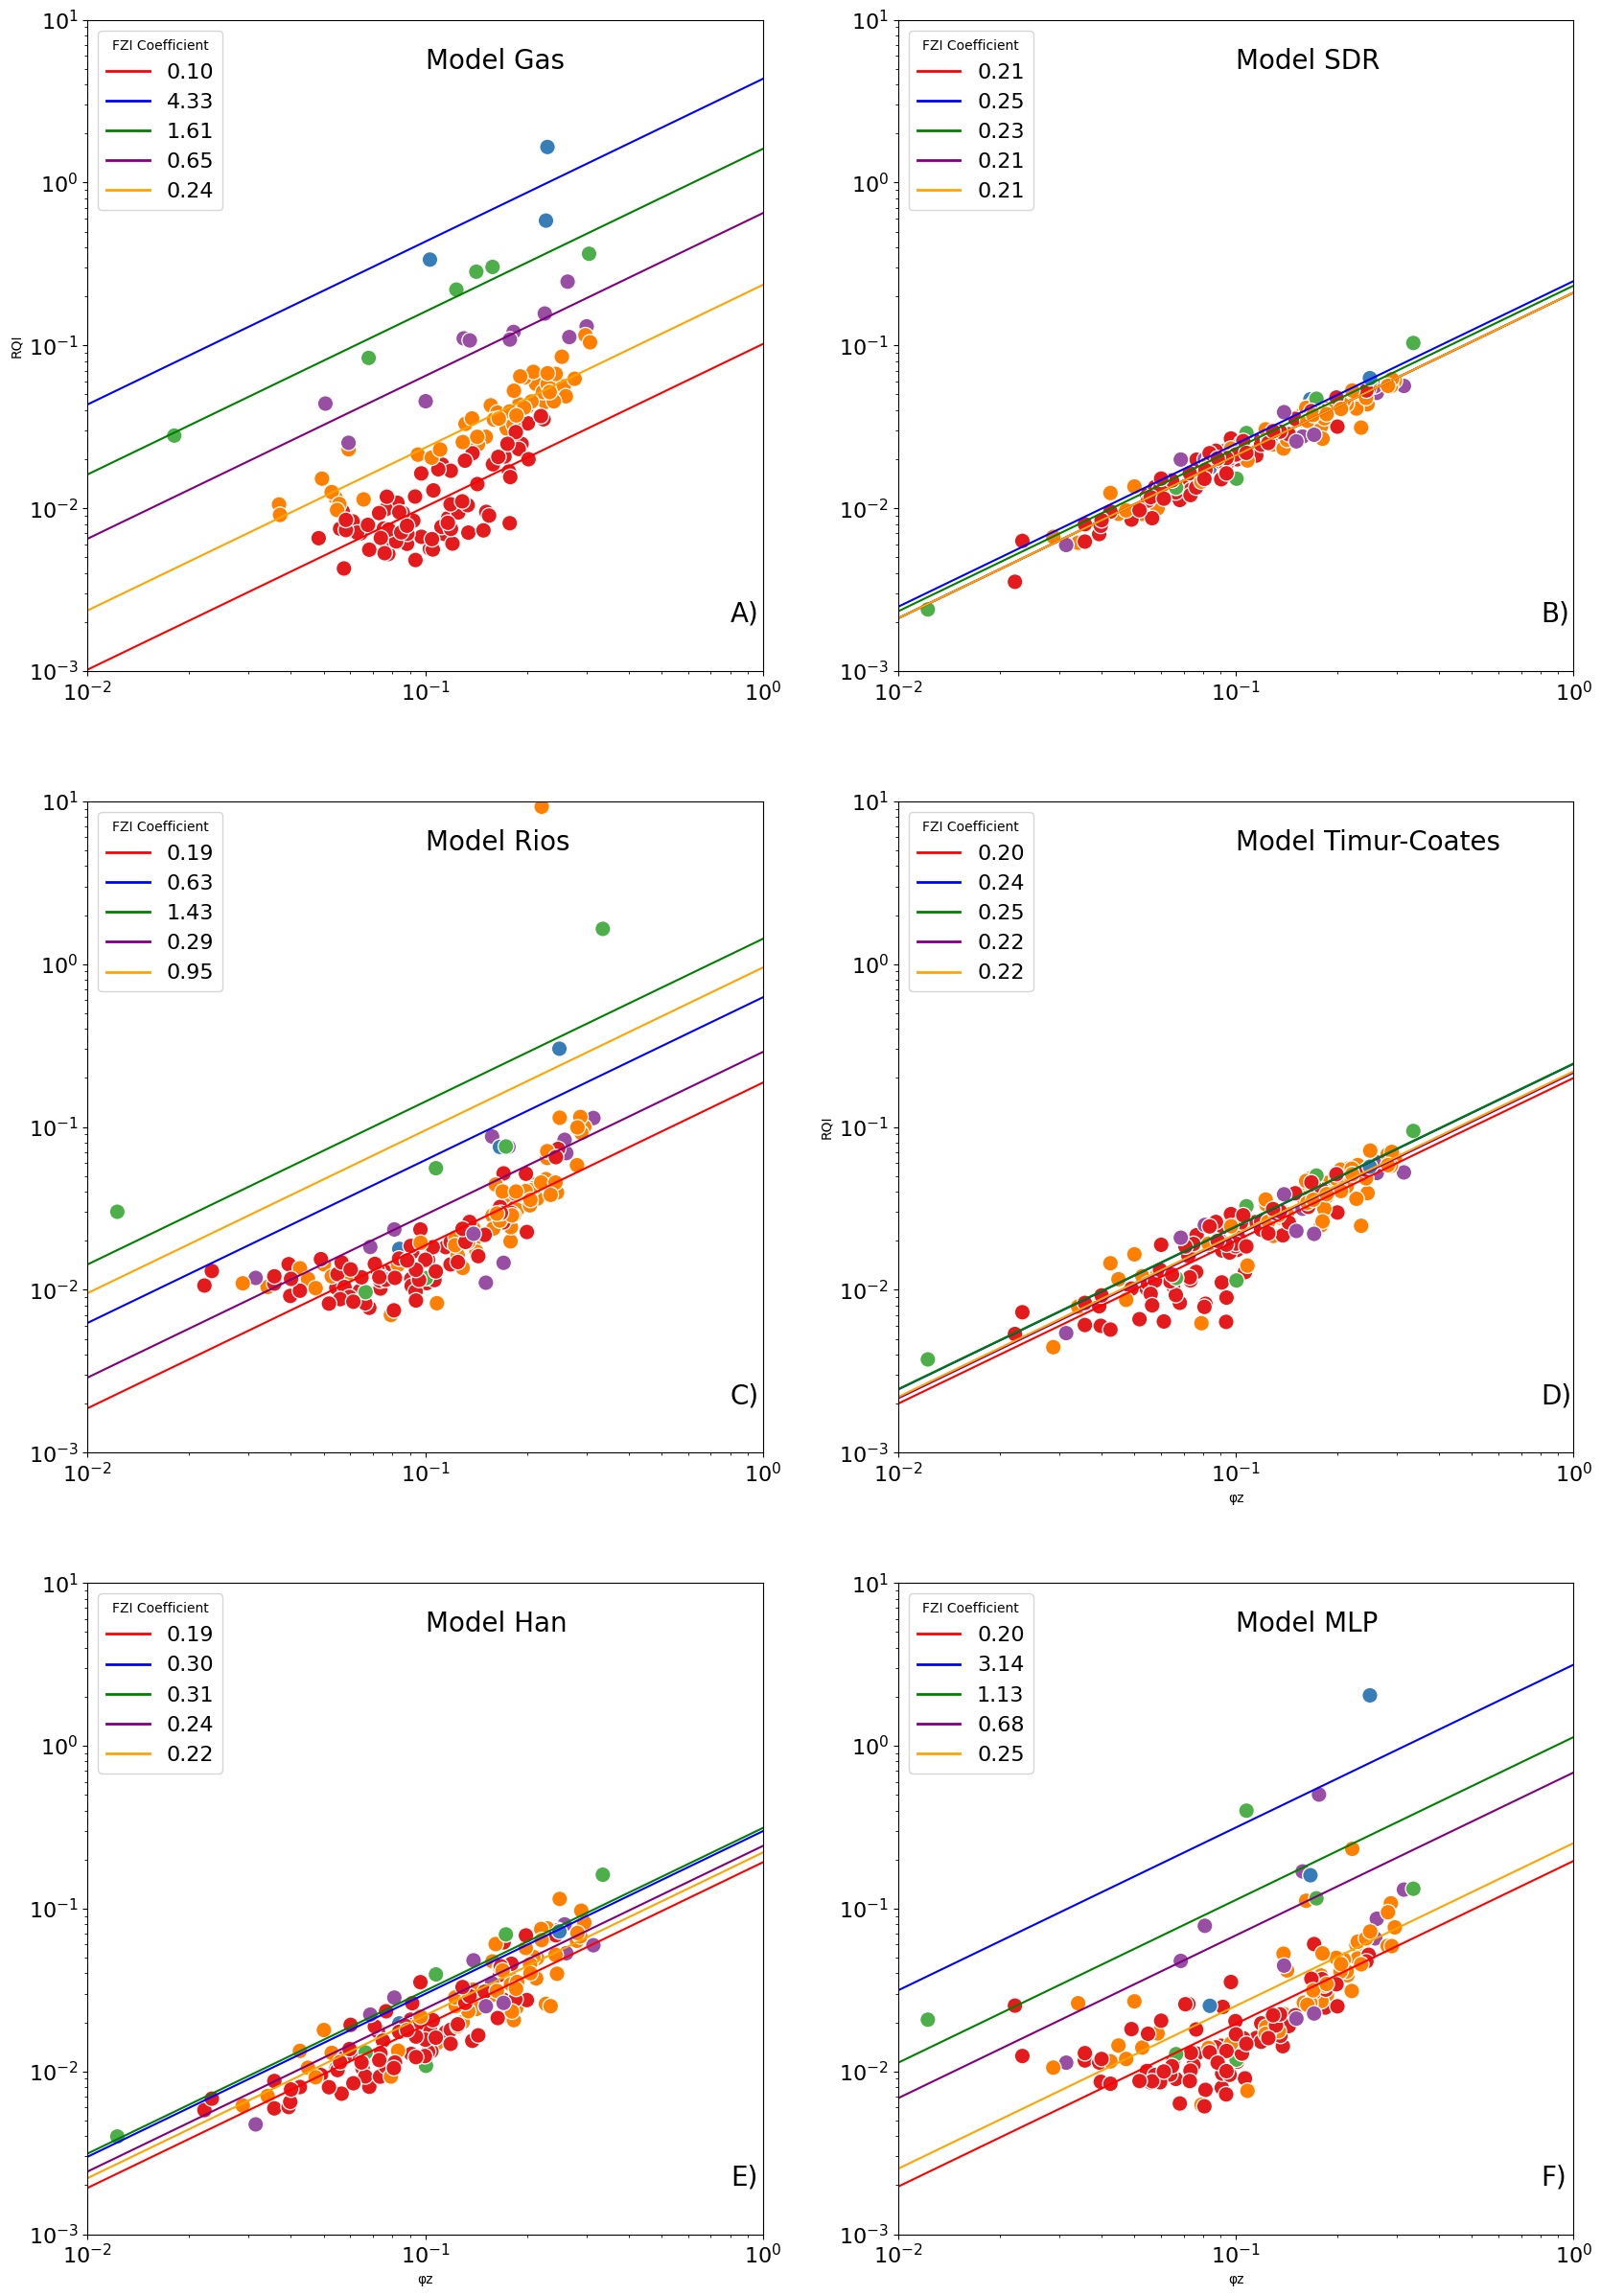

In [ ]:
fig = plt.figure(figsize = (20,30))
ax1 = fig.add_subplot(321)
VisualizarRQI(df_teste, coef_teste, 'Phi_z_Gas', 'RQI_Gas', 'Gas')
ax1.text(0.8, 0.002, 'A)', fontsize = 20)
ax1.text(0.1, 5, "Model Gas", fontsize = 20)
ax1.set_xlabel('')

ax2 = fig.add_subplot(322)
VisualizarRQI(df_teste, coef_teste, 'Phi_z_RMN', 'RQI_SDR', 'SDR')
ax2.text(0.8, 0.002, 'B)', fontsize = 20)
ax2.text(0.1, 5, "Model SDR", fontsize = 20)
ax2.set_xlabel('')
ax2.set_ylabel('')

ax3 = fig.add_subplot(323)
VisualizarRQI(df_teste, coef_teste, 'Phi_z_RMN', 'RQI_Rios', 'Rios')
ax3.text(0.8, 0.002, 'C)', fontsize = 20)
ax3.text(0.1, 5, "Model Rios", fontsize = 20)
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4 = fig.add_subplot(324)
VisualizarRQI(df_teste, coef_teste, 'Phi_z_RMN', 'RQI_Coates', 'Coates')
ax4.text(0.8, 0.002, 'D)', fontsize = 20)
ax4.text(0.1, 5, "Model Timur-Coates", fontsize = 20)

ax5 = fig.add_subplot(325)
VisualizarRQI(df_teste, coef_teste, 'Phi_z_RMN', 'RQI_Han', 'Han')
ax5.text(0.8, 0.002, 'E)', fontsize = 20)
ax5.text(0.1, 5, "Model Han", fontsize = 20)
ax5.set_ylabel('')

ax6 = fig.add_subplot(326)
VisualizarRQI(df_teste, coef_teste, 'Phi_z_RMN', 'RQI_MLP', 'MLP')
ax6.text(0.8, 0.002, 'F)', fontsize = 20)
ax6.text(0.1, 5, "Model MLP", fontsize = 20)
ax6.set_ylabel('')

In [ ]:
df_treino[['FZI_coef_Gas','FZI_Cluster', 'FZI_coef_SDR']].head()

FZI_coef_Gas  FZI_Cluster  FZI_coef_SDR
0      0.440557            4      0.228849
1      0.117679            0      0.184954
2      1.273730            2      0.261851
3      0.202306            5      0.214994
4      0.076071            0      0.138432

In [ ]:
df_combined_treino = pd.merge(df_treino, coef_treino, on='FZI_Cluster', how='left')
df_combined_teste = pd.merge(df_teste, coef_teste, on='FZI_Cluster', how='left')

In [ ]:
def PolarArmAngle(Dados, phi = ['Phi_z_RMN'], fzi = ['FZI_coef_SDR_y']):

  polar_arm = []
  porlar_angle = []

  phi_z_gas = Dados['Phi_z_Gas']
  fzi_gas = Dados['FZI_coef_Gas_x']
  colunas_arm = ['Polar_Arm_Gas']
  colunas_angle = ['Polar_Angle_Gas']

  polar_arm.append(phi_z_gas*(np.sqrt(fzi_gas**2 + 1)))
  porlar_angle.append(np.arctan(fzi_gas))

  for i in np.arange(len(fzi)):
    phi_z_mod = Dados['Phi_z_RMN']
    fzi_gas_mod = Dados[fzi[i]]
    arm_mod = phi_z_mod*(np.sqrt(fzi_gas_mod**2 + 1))
    angle_mod = np.arctan(fzi_gas_mod)
    polar_arm.append(arm_mod)
    porlar_angle.append(angle_mod)
    colunas_arm.append('Polar_Arm_' + fzi[i][9:-2])
    colunas_angle.append('Polar_Angle_' + fzi[i][9:-2])

  df_arn = pd.DataFrame(polar_arm).T
  df_arn.columns = colunas_arm

  df_angle = pd.DataFrame(porlar_angle).T
  df_angle.columns = colunas_angle

  df = pd.concat([Dados, df_arn, df_angle], axis = 1)

  return df


def VisualizarSigmoid(dados, modelo, Hue = 'FZI_Cluster'):
  # Coeficientes da Literatura
  A = -3.5916207
  B = 5.06265818
  C = -0.72243226
  D = 0.371324681


  pontos = np.arange(0, 15, 15/len(dados))
  sigmoid = A + B / (1 + (np.exp(-(pontos - C)/D)))
  eixo_x = r'$r$'
  eixo_y = r'$\theta_{\mathrm{polar}}$'


  sns.lineplot(dados, x = pontos, y = sigmoid)
  sns.scatterplot(dados, x = 'Polar_Arm_' + modelo, y = 'Polar_Angle_' + modelo, hue = Hue, palette = 'Set1')

  plt.xlabel(eixo_x, fontsize = 14)                                                                 # Determinando os nomes
  plt.ylabel(eixo_y, fontsize = 14)
  plt.legend(loc='lower center', fontsize=14, title="FZI Coefficient")

  plt.xlim(0.01, 2.5)
  plt.ylim(0.01, 2)

In [ ]:
df_Polar_treino = PolarArmAngle(df_combined_treino, fzi = ['FZI_coef_SDR_x', 'FZI_coef_Han_x', 'FZI_coef_Ge_x',
                                                           'FZI_coef_Coates_x', 'FZI_coef_Rios_x', 'FZI_coef_MLP_x'])
df_Polar_teste = PolarArmAngle(df_combined_teste, fzi = ['FZI_coef_SDR_x', 'FZI_coef_Han_x', 'FZI_coef_Ge_x',
                                                           'FZI_coef_Coates_x', 'FZI_coef_Rios_x', 'FZI_coef_MLP_x'])



In [ ]:
#salvar = '/content/drive/MyDrive/X Simpósio SBGf /Dados Gerados/'
#salvar_polar_treino = salvar + 'Polar_Treino.xlsx'
#salvar_polar_teste = salvar + 'Polar_Teste.xlsx'

#salvar_coef_teste = salvar + 'Coef_FZI_Teste.xlsx'
#salvar_coef_treino = salvar + 'Coef_FZI_Treino.xlsx'

#df_Polar_treino.to_excel(salvar_polar_treino)
#df_Polar_teste.to_excel(salvar_polar_teste)

#coef_treino.to_excel(salvar_coef_treino)
#coef_teste.to_excel(salvar_coef_teste)

### Visualizando o Sigmoid

In [ ]:
def VisualizarSigmoid(dados, modelo, Hue = 'FZI_Cluster'):
  # Coeficientes da Literatura
  A = -3.5916207
  B = 5.06265818
  C = -0.72243226
  D = 0.371324681


  pontos = np.arange(0, 15, 15/len(dados))
  sigmoid = A + B / (1 + (np.exp(-(pontos - C)/D)))
  eixo_x = r'$r$'
  eixo_y = r'$\theta_{\mathrm{polar}}$'


  sns.lineplot(dados, x = pontos, y = sigmoid)
  sns.scatterplot(dados, x = 'Polar_Arm_' + modelo, y = 'Polar_Angle_' + modelo, hue = Hue, palette = 'Set1', s = 140)

  plt.xlabel(eixo_x, fontsize = 16)                                                                 # Determinando os nomes
  plt.ylabel(eixo_y, fontsize = 16)

  plt.xlim(0.01, 2.5)
  plt.ylim(0.01, 2)

Text(2, 0.25, 'F)')

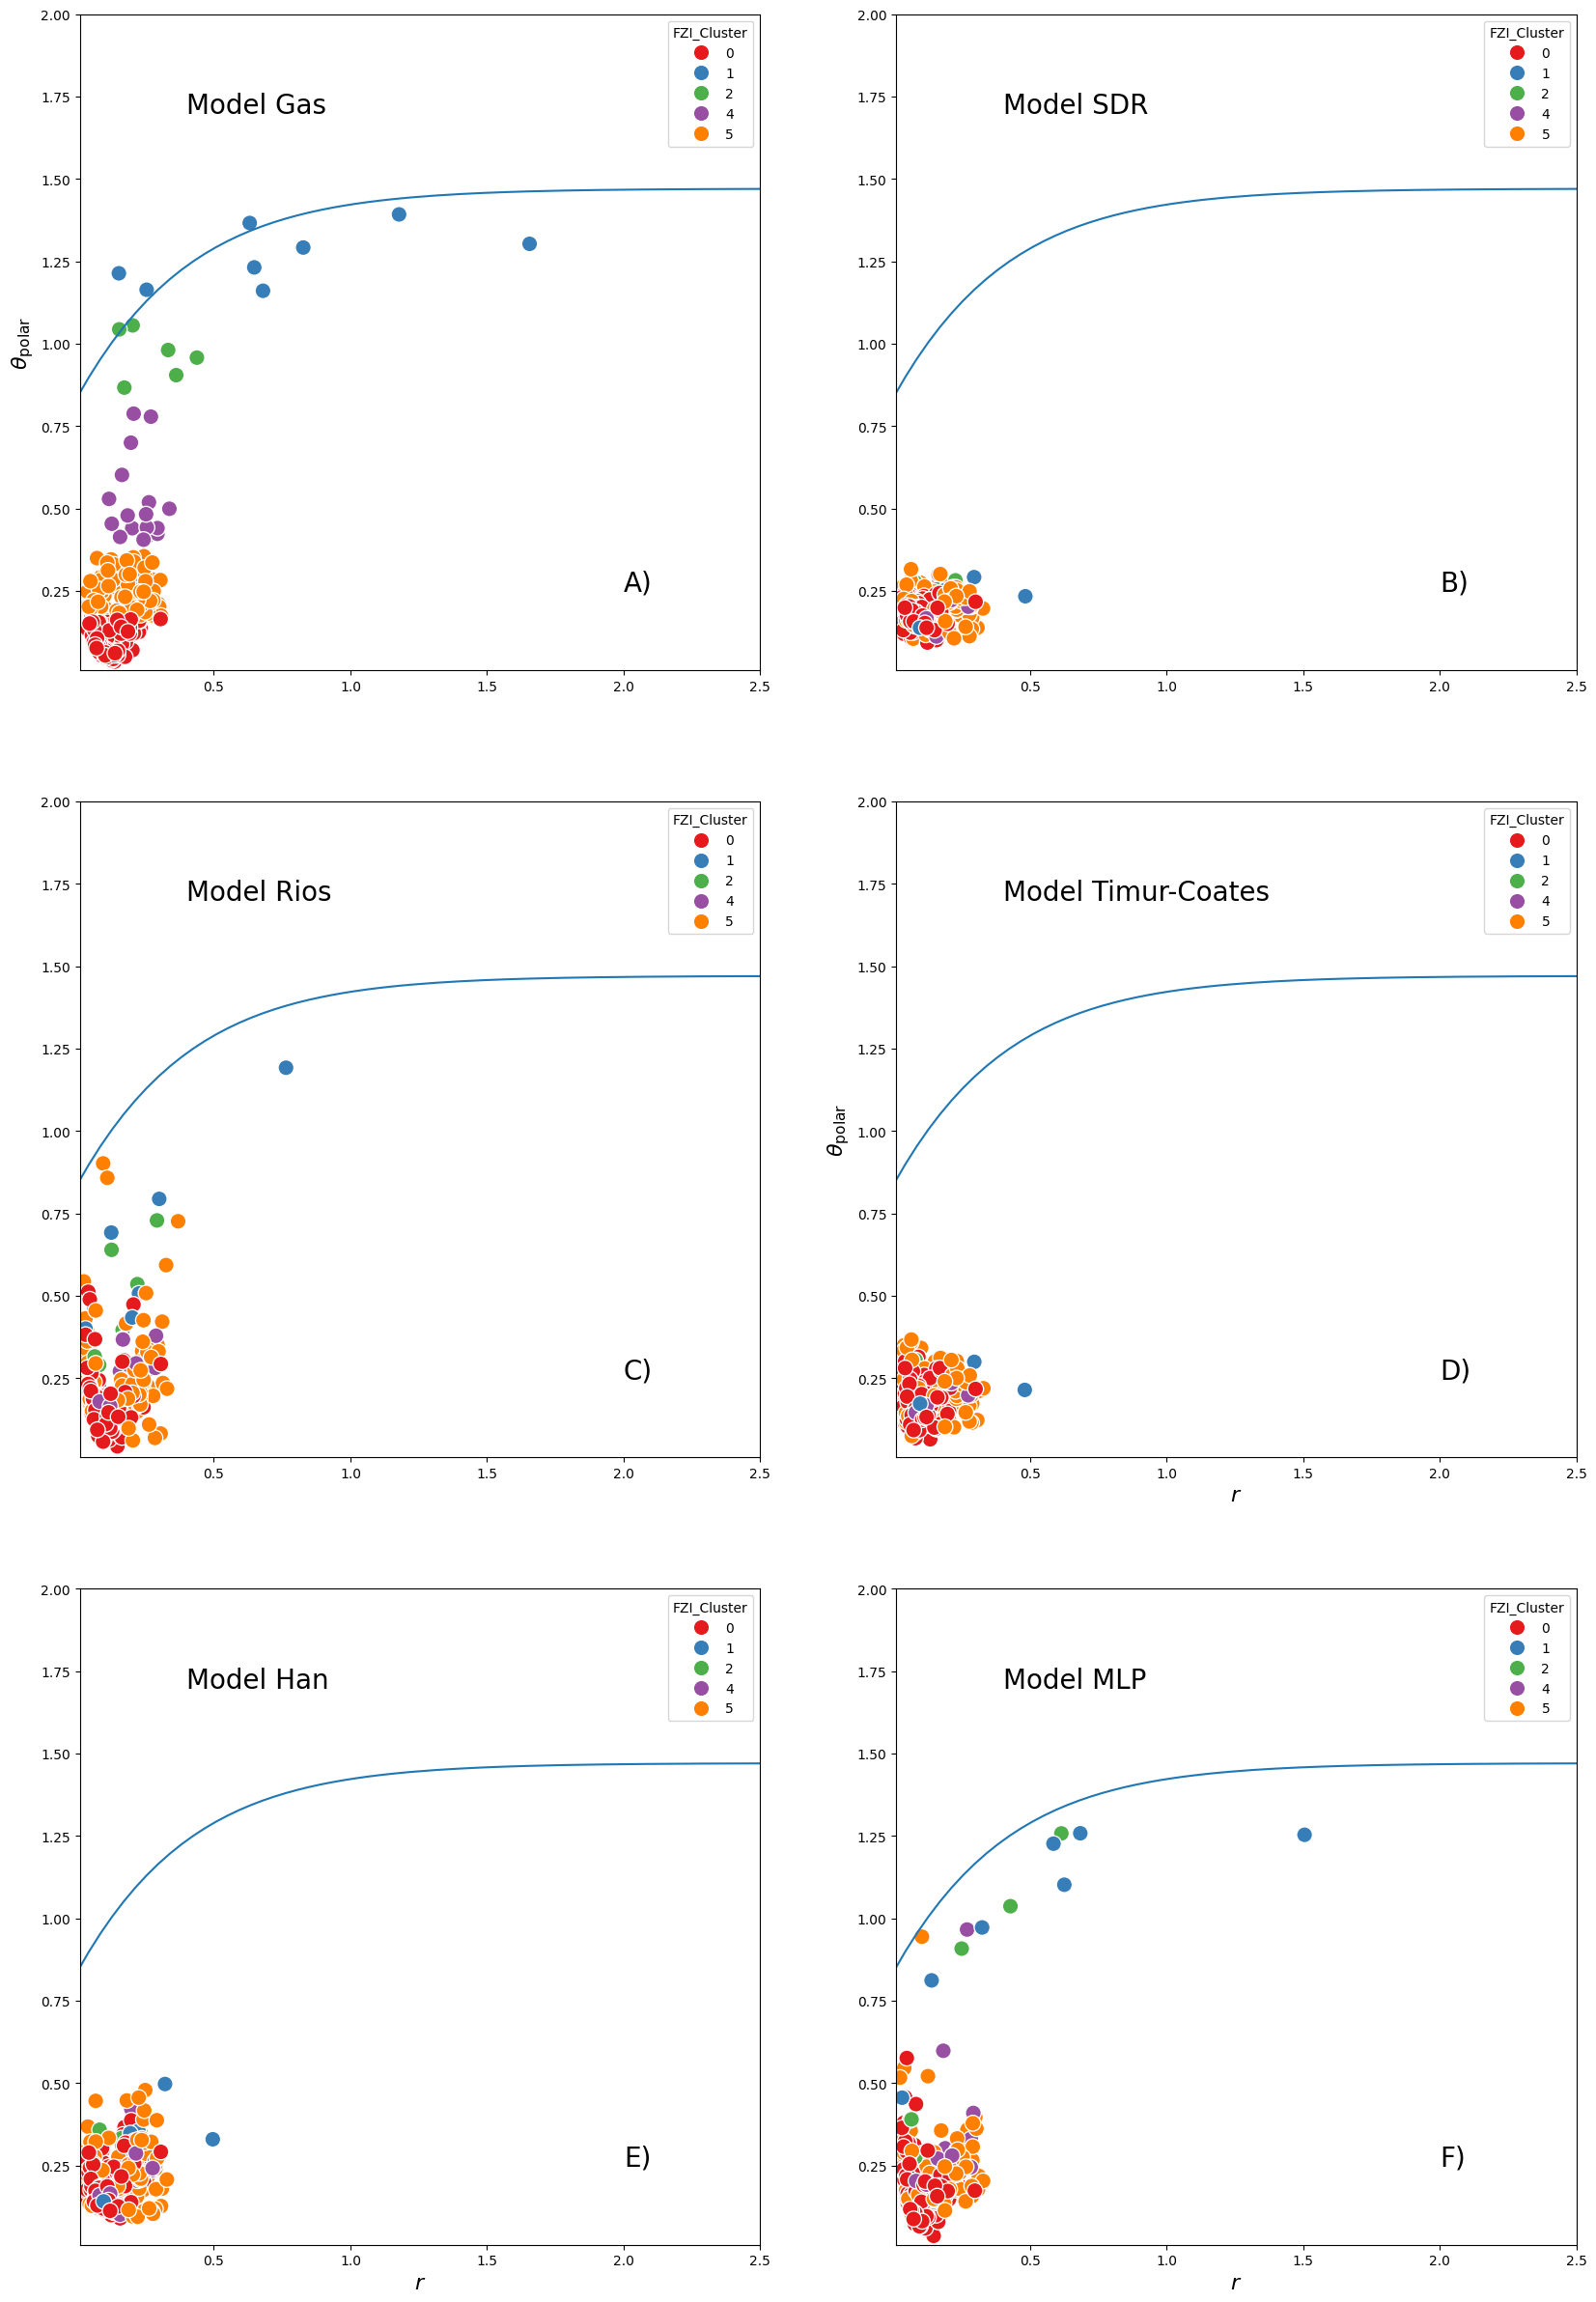

In [ ]:
fig = plt.figure(figsize = (20,30))
ax1 = fig.add_subplot(321)
VisualizarSigmoid(df_treino, 'Gas')
ax1.text(0.4, 1.7, 'Model Gas', fontsize = 20)
ax1.set_xlabel('')
ax1.text(2, 0.25, 'A)', fontsize = 20)

ax2 = fig.add_subplot(322)
VisualizarSigmoid(df_treino, 'SDR')
ax2.text(0.4, 1.7,  'Model SDR', fontsize = 20)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.text(2, 0.25, 'B)', fontsize = 20)

ax3 = fig.add_subplot(323)
VisualizarSigmoid(df_treino, 'Rios')
ax3.text(0.4, 1.7, 'Model Rios', fontsize = 20)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.text(2, 0.25, 'C)', fontsize = 20)

ax4 = fig.add_subplot(324)
VisualizarSigmoid(df_treino, 'Coates')
ax4.text(0.4, 1.7, 'Model Timur-Coates', fontsize = 20)
ax4.text(2, 0.25, 'D)', fontsize = 20)

ax5 = fig.add_subplot(325)
VisualizarSigmoid(df_treino, 'Han')
ax5.text(0.4, 1.7, 'Model Han', fontsize = 20)
ax5.set_ylabel('')
ax5.text(2, 0.25, 'E)', fontsize = 20)

ax6 = fig.add_subplot(326)
VisualizarSigmoid(df_treino, 'MLP')
ax6.text(0.4, 1.7, 'Model MLP', fontsize = 20)
ax6.set_ylabel('')
ax6.text(2, 0.25, 'F)', fontsize = 20)

Text(2, 0.25, 'F)')

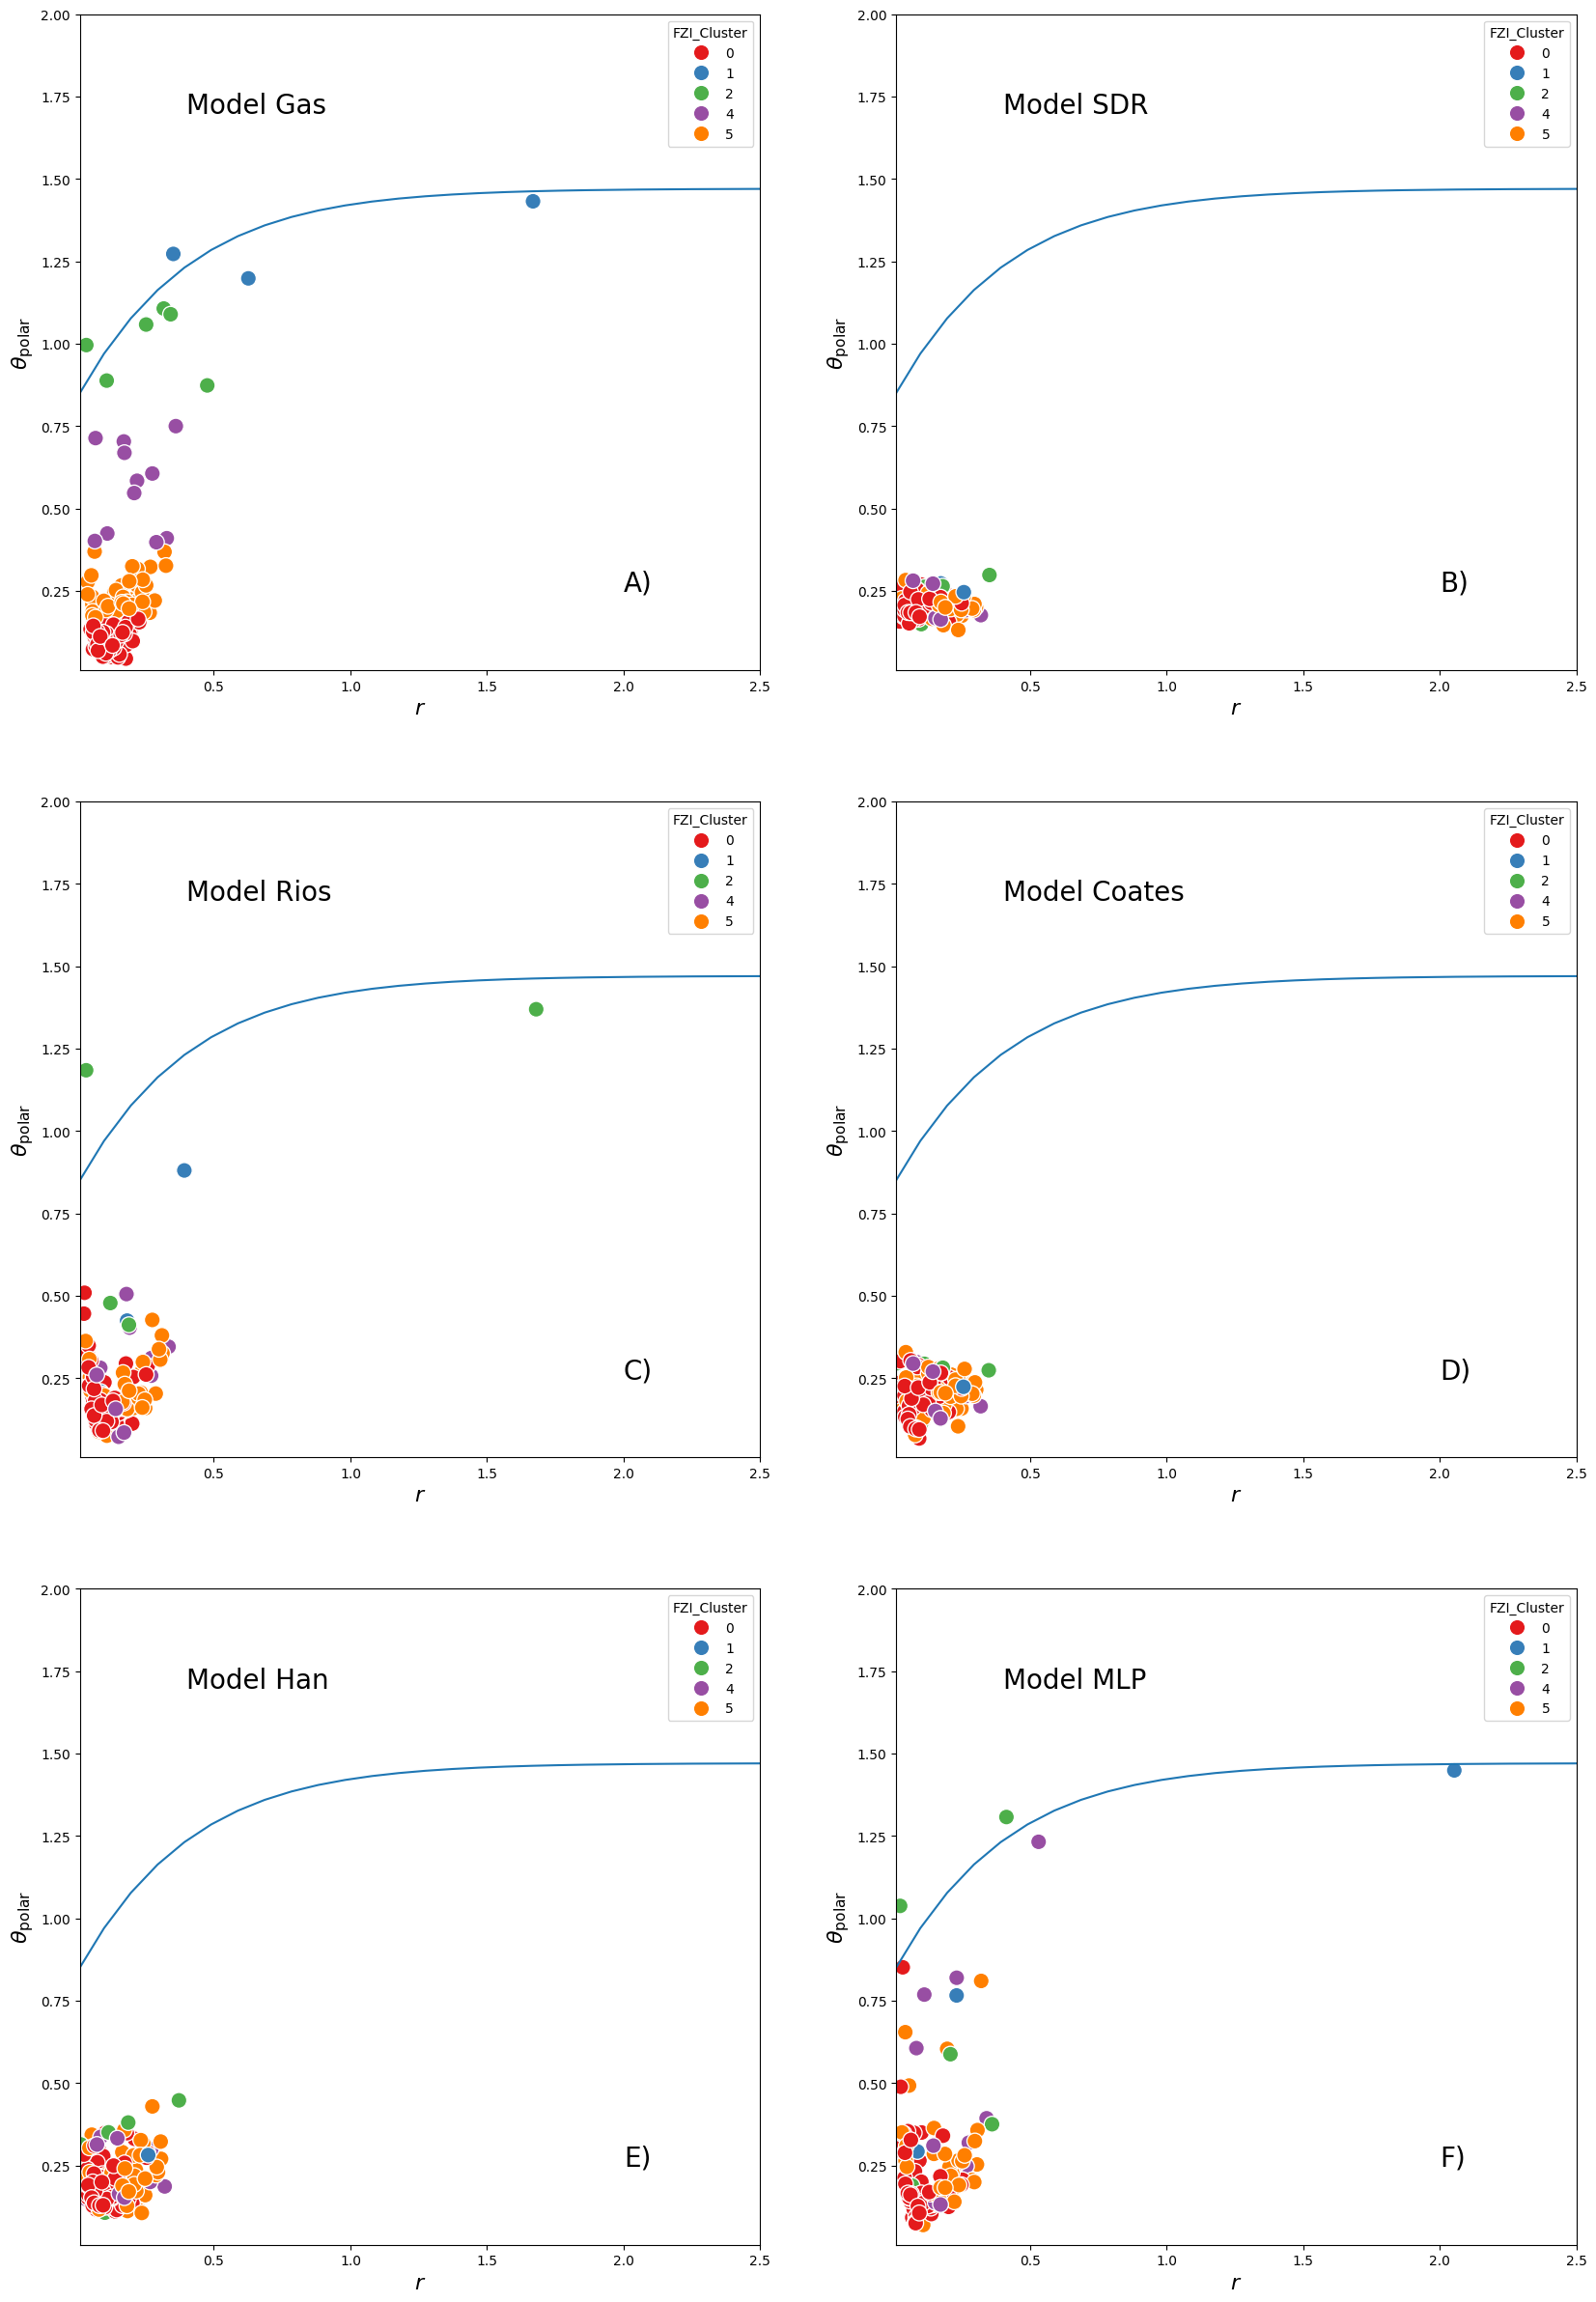

In [ ]:
fig = plt.figure(figsize = (20,30))
ax1 = fig.add_subplot(321)
VisualizarSigmoid(df_teste, 'Gas')
ax1.text(0.4, 1.7, 'Model Gas', fontsize = 20)
#ax1.set_xlabel('')
ax1.text(2, 0.25, 'A)', fontsize = 20)

ax2 = fig.add_subplot(322)
VisualizarSigmoid(df_teste, 'SDR')
ax2.text(0.4, 1.7,  'Model SDR', fontsize = 20)
#ax2.set_xlabel('')
#ax2.set_ylabel('')
ax2.text(2, 0.25, 'B)', fontsize = 20)

ax3 = fig.add_subplot(323)
VisualizarSigmoid(df_teste, 'Rios')
ax3.text(0.4, 1.7, 'Model Rios', fontsize = 20)
#ax3.set_xlabel('')
#ax3.set_ylabel('')
ax3.text(2, 0.25, 'C)', fontsize = 20)

ax4 = fig.add_subplot(324)
VisualizarSigmoid(df_teste, 'Coates')
ax4.text(0.4, 1.7, 'Model Coates', fontsize = 20)
ax4.text(2, 0.25, 'D)', fontsize = 20)

ax5 = fig.add_subplot(325)
VisualizarSigmoid(df_teste, 'Han')
ax5.text(0.4, 1.7, 'Model Han', fontsize = 20)
#ax5.set_ylabel('')
ax5.text(2, 0.25, 'E)', fontsize = 20)

ax6 = fig.add_subplot(326)
VisualizarSigmoid(df_teste, 'MLP')
ax6.text(0.4, 1.7, 'Model MLP', fontsize = 20)
#ax6.set_ylabel('')
ax6.text(2, 0.25, 'F)', fontsize = 20)

## Avaliação dos Erros

In [ ]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

In [ ]:
df_treino[['FZI_coef_Gas_y', 'FZI_coef_Coates_x', 'FZI_coef_SDR_y', 'FZI_Cluster']]

FZI_coef_Gas_y  FZI_coef_Coates_x  FZI_coef_SDR_y  FZI_Cluster
0          0.584802           0.249063        0.203990            4
1          0.103177           0.228919        0.190270            0
2          1.476674           0.273868        0.234703            2
3          0.240382           0.234586        0.205679            5
4          0.103177           0.108501        0.190270            0
..              ...                ...             ...          ...
349        3.460591           0.175024        0.225463            1
350        0.103177           0.101188        0.190270            0
351        0.103177           0.133586        0.190270            0
352        0.240382           0.103424        0.205679            5
353        0.103177           0.194911        0.190270            0

[354 rows x 4 columns]

In [ ]:
np.array(df_treino.columns)

array(['Amostra', 'Poço', 'Litofacies', 'Categoria Litofacies',
       'Bioturbiditos', 'Dolowackstone', 'Grainstone', 'Brechado',
       'Packstone', 'Porosidade Gas', 'Porosidade RMN',
       'Permeabilidade Gas', 'Fracao Argila', 'Fitting Error',
       'T2 Ponderado Log', 'S1Han', 'S2Han', 'S3Han', 'S4Han', 'S1Ge',
       'S3Ge', 'S4Ge', 'BVI', 'FFI', 'T2 0.01', 'T2 0.011', 'T2 0.012',
       'T2 0.014', 'T2 0.015', 'T2 0.017', 'T2 0.019', 'T2 0.021',
       'T2 0.024', 'T2 0.027', 'T2 0.03', 'T2 0.033', 'T2 0.037',
       'T2 0.041', 'T2 0.046', 'T2 0.051', 'T2 0.057', 'T2 0.064',
       'T2 0.071', 'T2 0.079', 'T2 0.088', 'T2 0.098', 'T2 0.109',
       'T2 0.122', 'T2 0.136', 'T2 0.152', 'T2 0.169', 'T2 0.189',
       'T2 0.21', 'T2 0.234', 'T2 0.261', 'T2 0.291', 'T2 0.325',
       'T2 0.362', 'T2 0.404', 'T2 0.45', 'T2 0.502', 'T2 0.56',
       'T2 0.624', 'T2 0.696', 'T2 0.776', 'T2 0.865', 'T2 0.964',
       'T2 1.075', 'T2 1.199', 'T2 1.337', 'T2 1.49', 'T2 1.661',
       'T

In [ ]:
def ErrosPerm (dados, modelos):

  max = []
  min = []
  media = []
  r2 = []
  rmse_log = []

  for i in modelos:

    if i == 'Gas':
      gas = np.log10(dados['Permeabilidade Gas']*1000)
      modelo = np.log10(dados['Permeabilidade Gas']*1000)
      max.append(dados[f'Permeabilidade Gas'].max())
      min.append(dados[f'Permeabilidade Gas'].min())
      media.append(np.mean(dados[f'Permeabilidade Gas']))
      r2.append(r2_score(gas, modelo))
      rmse_log.append(10**root_mean_squared_error(gas, modelo))
    else:
      gas = np.log10(dados['Permeabilidade Gas']*1000)
      modelo = np.log10(dados[f'Permeabilidade Prevista {i}']*1000)
      max.append(dados[f'Permeabilidade Prevista {i}'].max())
      min.append(dados[f'Permeabilidade Prevista {i}'].min())
      media.append(np.mean(dados[f'Permeabilidade Prevista {i}']))
      r2.append(r2_score(gas, modelo))
      rmse_log.append(10**root_mean_squared_error(gas, modelo))




  df = pd.DataFrame({'Modelos': modelos,
                     'Max': max,
                     'Min': min,
                     'Media': media,
                     'R2': r2,
                     'RMSE Log': rmse_log})
  return df.set_index('Modelos')






def ErrosFZI(dados, modelos):
  dfs = []

  for cluster in dados['FZI_Cluster'].unique():
    # Filtrando os dados por cluster
    cluster_data = dados[dados['FZI_Cluster'] == cluster]
    max = []
    min = []
    media = []
    r2 = []
    rmse= []
    cluster = []

    for j in modelos:
      gas = cluster_data[f'FZI_coef_Gas_y']
      modelo = cluster_data[f'FZI_coef_{j}_y']
      max.append(cluster_data[f'FZI_coef_{j}_y'].max())
      min.append(cluster_data[f'FZI_coef_{j}_y'].min())
      media.append(np.mean(cluster_data[f'FZI_coef_{j}_y']))
      r2.append(r2_score(gas, modelo))
      rmse.append(root_mean_squared_error(gas, modelo))
      reset = cluster_data.reset_index()
      cluster.append(reset['FZI_Cluster'][0])

    df = pd.DataFrame({'Modelos': modelos,
                     'Max': max,
                     'Min': min,
                     'Media': media,
                     'R2': r2,
                     'RMSE': rmse,
                     'Cluster': cluster})

    dfs.append(df)

  return dfs


In [ ]:
erros_treino = ErrosPerm(df_treino, ['Gas', 'SDR', 'Han', 'Ge', 'Coates', 'Rios', 'MLP'])
erros_teste = ErrosPerm(df_teste, ['Gas', 'SDR', 'Han', 'Ge', 'Coates', 'Rios', 'MLP'])
erros_teste

Max       Min       Media        R2  RMSE Log
Modelos                                                        
Gas        517.279000  0.001000    4.623255  1.000000  1.000000
SDR          2.719834  0.000070    0.175922  0.523400  5.861509
Han          6.617456  0.000194    0.259649  0.581928  5.239719
Ge          90.911678  0.000180    1.139485  0.420790  7.025170
Coates       2.272709  0.000171    0.184830  0.542374  5.656740
Rios     15750.869624  0.002477  107.808036  0.558220  5.488106
MLP        839.998785  0.002609    6.204576  0.715163  3.923991

In [ ]:
erros_fzi_treino = ErrosFZI(df_treino, ['Gas', 'SDR', 'Han', 'Coates', 'Rios', 'MLP'])
erros_fzi_teste = ErrosFZI(df_teste, ['Gas', 'SDR', 'Han', 'Coates', 'Rios', 'MLP'])
erros_fzi_treino[2]

Modelos       Max       Min     Media   R2      RMSE  Cluster
0     Gas  1.476674  1.476674  1.476674  1.0  0.000000        2
1     SDR  0.234703  0.234703  0.234703  0.0  1.241971        2
2     Han  0.307850  0.307850  0.307850  0.0  1.168824        2
3  Coates  0.259653  0.259653  0.259653  0.0  1.217022        2
4    Rios  0.546289  0.546289  0.546289  0.0  0.930385        2
5     MLP  1.175620  1.175620  1.175620  0.0  0.301054        2

In [ ]:
coef_treino

FZI_Cluster  FZI_coef_Gas  FZI_coef_SDR  FZI_coef_Han  FZI_coef_Ge  \
0            0      0.103177      0.190270      0.183075     0.340111   
1            1      3.460591      0.225463      0.321980     0.660862   
2            2      1.476674      0.234703      0.307850     0.517962   
3            4      0.584802      0.203990      0.244754     0.375347   
4            5      0.240382      0.205679      0.225469     0.362604   

   FZI_coef_Coates  FZI_coef_Rios  FZI_coef_MLP  
0         0.188532       0.174551      0.169145  
1         0.251243       3.047164      1.790771  
2         0.259653       0.546289      1.175620  
3         0.214439       0.270267      0.356617  
4         0.218884       0.245708      0.238239

In [ ]:
erros_fzi_teste[0]

Modelos       Max       Min     Media         R2      RMSE  Cluster
0     Gas  0.932615  0.420974  0.649125   1.000000  0.000000        4
1     SDR  0.289424  0.165565  0.210765  -5.535143  0.474186        4
2     Han  0.350446  0.150155  0.242586  -4.934445  0.451867        4
3  Coates  0.308723  0.129265  0.215194  -5.512815  0.473375        4
4    Rios  0.553797  0.073119  0.288941  -4.843754  0.448401        4
5     MLP  2.840770  0.132888  0.684195 -15.958187  0.763855        4

# Regressão PLSR

In [ ]:
treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados RMN/Dados_Reservatórios_treino_15_06.xlsx').drop('Unnamed: 0', axis = 1)
teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados RMN/Dados_Reservatórios_teste_15_06.xlsx').drop('Unnamed: 0', axis = 1)

X_treino = treino[['T2 0.01',  'T2 0.011',  'T2 0.012',  'T2 0.014',  'T2 0.015',  'T2 0.017',  'T2 0.019',  'T2 0.021',  'T2 0.024',
           'T2 0.027',  'T2 0.03',  'T2 0.033',  'T2 0.037',  'T2 0.041',  'T2 0.046',  'T2 0.051',  'T2 0.057',  'T2 0.064',
           'T2 0.071',  'T2 0.079',  'T2 0.088',  'T2 0.098',  'T2 0.109',  'T2 0.122',  'T2 0.136',  'T2 0.152',  'T2 0.169',
           'T2 0.189',  'T2 0.21',  'T2 0.234',  'T2 0.261',  'T2 0.291',  'T2 0.325',  'T2 0.362',  'T2 0.404',  'T2 0.45',
           'T2 0.502',  'T2 0.56',  'T2 0.624',  'T2 0.696',  'T2 0.776',  'T2 0.865',  'T2 0.964',  'T2 1.075',  'T2 1.199',
           'T2 1.337',  'T2 1.49',  'T2 1.661',  'T2 1.852',  'T2 2.065',  'T2 2.303',  'T2 2.567',  'T2 2.862',  'T2 3.191',
           'T2 3.558',  'T2 3.967',  'T2 4.423',  'T2 4.931',  'T2 5.497',  'T2 6.129',  'T2 6.834',  'T2 7.619',  'T2 8.494',
           'T2 9.471',  'T2 10.559',  'T2 11.772',  'T2 13.125',  'T2 14.634',  'T2 16.315',  'T2 18.19',  'T2 20.281',  'T2 22.612',
           'T2 25.21',  'T2 28.107',  'T2 31.337',  'T2 34.939',  'T2 38.954',  'T2 43.431',  'T2 48.422',  'T2 53.986',  'T2 60.19',
           'T2 67.108',  'T2 74.82',  'T2 83.418',  'T2 93.004',  'T2 103.693',  'T2 115.609',  'T2 128.895',  'T2 143.708',  'T2 160.223',
           'T2 178.636',  'T2 199.165',  'T2 222.053',  'T2 247.572',  'T2 276.023',  'T2 307.744',  'T2 343.11',  'T2 382.54',  'T2 426.502',
           'T2 475.516',  'T2 530.163',  'T2 591.09',  'T2 659.019',  'T2 734.754',  'T2 819.192',  'T2 913.335',  'T2 1018.296',  'T2 1135.32',
           'T2 1265.792',  'T2 1411.258',  'T2 1573.441',  'T2 1754.262',  'T2 1955.864',  'T2 2180.633',  'T2 2431.234',  'T2 2710.634',  'T2 3022.143',
           'T2 3369.45',  'T2 3756.671',  'T2 4188.391',  'T2 4669.725',  'T2 5206.375',  'T2 5804.697',  'T2 6471.778',  'T2 7215.521',  'T2 8044.736',
           'T2 8969.245',  'T2 10000']]
y_treino = np.log10(treino['Permeabilidade Gas']*1000)

X_teste = teste[['T2 0.01',  'T2 0.011',  'T2 0.012',  'T2 0.014',  'T2 0.015',  'T2 0.017',  'T2 0.019',  'T2 0.021',  'T2 0.024',
           'T2 0.027',  'T2 0.03',  'T2 0.033',  'T2 0.037',  'T2 0.041',  'T2 0.046',  'T2 0.051',  'T2 0.057',  'T2 0.064',
           'T2 0.071',  'T2 0.079',  'T2 0.088',  'T2 0.098',  'T2 0.109',  'T2 0.122',  'T2 0.136',  'T2 0.152',  'T2 0.169',
           'T2 0.189',  'T2 0.21',  'T2 0.234',  'T2 0.261',  'T2 0.291',  'T2 0.325',  'T2 0.362',  'T2 0.404',  'T2 0.45',
           'T2 0.502',  'T2 0.56',  'T2 0.624',  'T2 0.696',  'T2 0.776',  'T2 0.865',  'T2 0.964',  'T2 1.075',  'T2 1.199',
           'T2 1.337',  'T2 1.49',  'T2 1.661',  'T2 1.852',  'T2 2.065',  'T2 2.303',  'T2 2.567',  'T2 2.862',  'T2 3.191',
           'T2 3.558',  'T2 3.967',  'T2 4.423',  'T2 4.931',  'T2 5.497',  'T2 6.129',  'T2 6.834',  'T2 7.619',  'T2 8.494',
           'T2 9.471',  'T2 10.559',  'T2 11.772',  'T2 13.125',  'T2 14.634',  'T2 16.315',  'T2 18.19',  'T2 20.281',  'T2 22.612',
           'T2 25.21',  'T2 28.107',  'T2 31.337',  'T2 34.939',  'T2 38.954',  'T2 43.431',  'T2 48.422',  'T2 53.986',  'T2 60.19',
           'T2 67.108',  'T2 74.82',  'T2 83.418',  'T2 93.004',  'T2 103.693',  'T2 115.609',  'T2 128.895',  'T2 143.708',  'T2 160.223',
           'T2 178.636',  'T2 199.165',  'T2 222.053',  'T2 247.572',  'T2 276.023',  'T2 307.744',  'T2 343.11',  'T2 382.54',  'T2 426.502',
           'T2 475.516',  'T2 530.163',  'T2 591.09',  'T2 659.019',  'T2 734.754',  'T2 819.192',  'T2 913.335',  'T2 1018.296',  'T2 1135.32',
           'T2 1265.792',  'T2 1411.258',  'T2 1573.441',  'T2 1754.262',  'T2 1955.864',  'T2 2180.633',  'T2 2431.234',  'T2 2710.634',  'T2 3022.143',
           'T2 3369.45',  'T2 3756.671',  'T2 4188.391',  'T2 4669.725',  'T2 5206.375',  'T2 5804.697',  'T2 6471.778',  'T2 7215.521',  'T2 8044.736',
           'T2 8969.245',  'T2 10000']]
y_teste = np.log10(teste['Permeabilidade Gas']*1000)


In [ ]:
pls6 = PLSRegression(n_components=6)
pls6.fit(X_treino, y_treino)
y_pred_treino = pls6.predict(X_treino)
y_pred_teste = pls6.predict(X_teste)

df_plsr_treino = pd.DataFrame({"Permeabilidade Gas": treino['Permeabilidade Gas'],
                               'Litofacies': treino['Litofacies'],
                               'Permeabilidade Prevista': treino['Permeabilidade Prevista PLSR']})
df_plsr_teste = pd.DataFrame({"Permeabilidade Gas": teste['Permeabilidade Gas'],
                              'Litofacies': teste['Litofacies'],
                               'Permeabilidade Prevista': teste['Permeabilidade Prevista PLSR']})

NameError: name 'X_treino' is not defined

In [ ]:
treino['Permeabilidade Prevista PLSR'] = (10**y_pred_treino)/1000
teste['Permeabilidade Prevista PLSR'] = (10**y_pred_teste)/1000

NameError: name 'y_pred_treino' is not defined

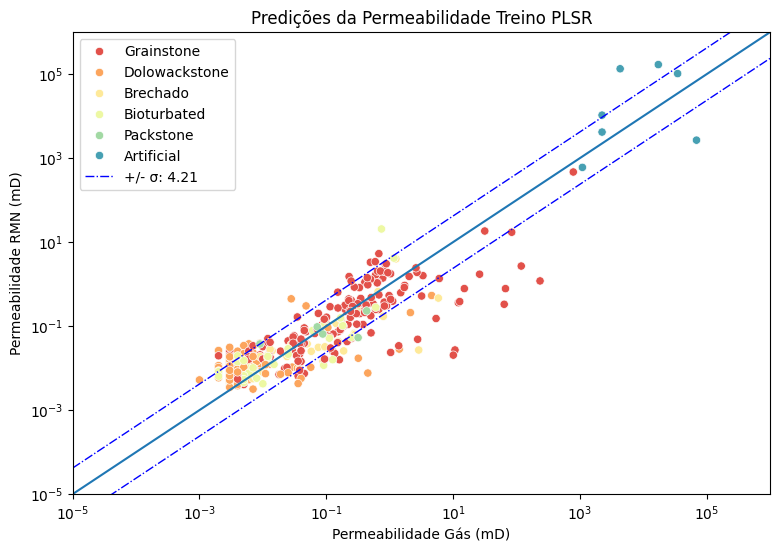

In [ ]:
#Erro Sigma
k_p = np.log10(treino['Permeabilidade Prevista PLSR'])
k_g = np.log10(treino['Permeabilidade Gas'])
N = len(k_p)
soma = np.sum((k_p-k_g)**2)
raiz = np.sqrt(soma/N)
sigma_sdr = 10**(raiz)

VisualizarPredicoes(df_plsr_treino, Sigma = True, Valor_Sigma = sigma_sdr, Litofacies = 'Litofacies', Modelo = 'Treino PLSR')

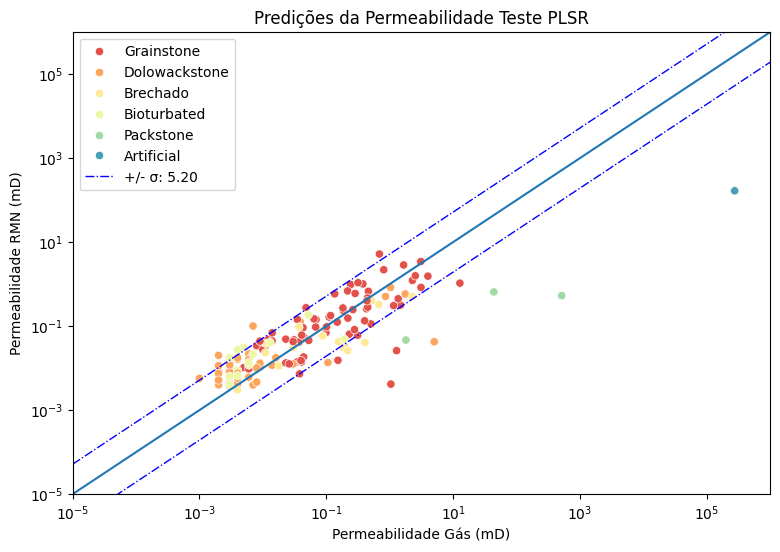

In [ ]:
#Erro Sigma
k_p = np.log10(teste['Permeabilidade Prevista PLSR'])
k_g = np.log10(teste['Permeabilidade Gas'])
N = len(k_p)
soma = np.sum((k_p-k_g)**2)
raiz = np.sqrt(soma/N)
sigma_sdr = 10**(raiz)

VisualizarPredicoes(df_plsr_teste, Sigma = True, Valor_Sigma = sigma_sdr, Litofacies = 'Litofacies', Modelo = 'Teste PLSR')

In [ ]:
np.array(teste.columns)

array(['Amostra', 'Poço', 'Litofacies', 'Categoria Litofacies',
       'Bioturbiditos', 'Dolowackstone', 'Grainstone', 'Brechado',
       'Packstone', 'Artificial', 'Porosidade Gas', 'Porosidade RMN',
       'Permeabilidade Gas', 'Fracao Argila', 'Fitting Error',
       'T2 Ponderado Log', 'S1Han', 'S2Han', 'S3Han', 'S4Han', 'S1Ge',
       'S3Ge', 'S4Ge', 'BVI', 'FFI', 'T2 0.01', 'T2 0.011', 'T2 0.012',
       'T2 0.014', 'T2 0.015', 'T2 0.017', 'T2 0.019', 'T2 0.021',
       'T2 0.024', 'T2 0.027', 'T2 0.03', 'T2 0.033', 'T2 0.037',
       'T2 0.041', 'T2 0.046', 'T2 0.051', 'T2 0.057', 'T2 0.064',
       'T2 0.071', 'T2 0.079', 'T2 0.088', 'T2 0.098', 'T2 0.109',
       'T2 0.122', 'T2 0.136', 'T2 0.152', 'T2 0.169', 'T2 0.189',
       'T2 0.21', 'T2 0.234', 'T2 0.261', 'T2 0.291', 'T2 0.325',
       'T2 0.362', 'T2 0.404', 'T2 0.45', 'T2 0.502', 'T2 0.56',
       'T2 0.624', 'T2 0.696', 'T2 0.776', 'T2 0.865', 'T2 0.964',
       'T2 1.075', 'T2 1.199', 'T2 1.337', 'T2 1.49', 'T2 1.6

# Aprendizado de máquina

## Dados para Treino

In [ ]:
treino = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados RMN/Dados_Reservatórios_treino_18_06.xlsx').drop('Unnamed: 0', axis = 1)
teste = pd.read_excel('/content/drive/MyDrive/X Simpósio SBGf /Dados RMN/Dados_Reservatórios_teste_18_06.xlsx').drop('Unnamed: 0', axis = 1)
treino.head(2)

Amostra  Poço  Litofacies  Categoria Litofacies  Bioturbiditos  \
0  AA01-A-05  AA01  Grainstone                     3              0   
1  AA01-A-09  AA01  Grainstone                     3              0   

   Dolowackstone  Grainstone  Brechado  Packstone  Porosidade Gas  ...  \
0              0           1         0          0         0.18920  ...   
1              0           1         0          0         0.08149  ...   

   Polar_arm_Ge  Polar_angle_Ge  RQI_Coates  FZI_Coates  Polar_arm_Coates  \
0      0.263086        0.352797    0.061489    0.249063          0.254425   
1      0.076790        0.335790    0.016597    0.228919          0.074376   

   Polar_angle_Coates  RQI_Rios  FZI_Rios  Polar_arm_Rios  Polar_angle_Rios  
0            0.244097  0.075180  0.304516        0.258076          0.295595  
1            0.225041  0.013237  0.182577        0.073700          0.180588  

[2 rows x 186 columns]

In [ ]:
X_treino = treino[['T2 0.01',  'T2 0.011',  'T2 0.012',  'T2 0.014',  'T2 0.015',  'T2 0.017',  'T2 0.019',  'T2 0.021',  'T2 0.024',
           'T2 0.027',  'T2 0.03',  'T2 0.033',  'T2 0.037',  'T2 0.041',  'T2 0.046',  'T2 0.051',  'T2 0.057',  'T2 0.064',
           'T2 0.071',  'T2 0.079',  'T2 0.088',  'T2 0.098',  'T2 0.109',  'T2 0.122',  'T2 0.136',  'T2 0.152',  'T2 0.169',
           'T2 0.189',  'T2 0.21',  'T2 0.234',  'T2 0.261',  'T2 0.291',  'T2 0.325',  'T2 0.362',  'T2 0.404',  'T2 0.45',
           'T2 0.502',  'T2 0.56',  'T2 0.624',  'T2 0.696',  'T2 0.776',  'T2 0.865',  'T2 0.964',  'T2 1.075',  'T2 1.199',
           'T2 1.337',  'T2 1.49',  'T2 1.661',  'T2 1.852',  'T2 2.065',  'T2 2.303',  'T2 2.567',  'T2 2.862',  'T2 3.191',
           'T2 3.558',  'T2 3.967',  'T2 4.423',  'T2 4.931',  'T2 5.497',  'T2 6.129',  'T2 6.834',  'T2 7.619',  'T2 8.494',
           'T2 9.471',  'T2 10.559',  'T2 11.772',  'T2 13.125',  'T2 14.634',  'T2 16.315',  'T2 18.19',  'T2 20.281',  'T2 22.612',
           'T2 25.21',  'T2 28.107',  'T2 31.337',  'T2 34.939',  'T2 38.954',  'T2 43.431',  'T2 48.422',  'T2 53.986',  'T2 60.19',
           'T2 67.108',  'T2 74.82',  'T2 83.418',  'T2 93.004',  'T2 103.693',  'T2 115.609',  'T2 128.895',  'T2 143.708',  'T2 160.223',
           'T2 178.636',  'T2 199.165',  'T2 222.053',  'T2 247.572',  'T2 276.023',  'T2 307.744',  'T2 343.11',  'T2 382.54',  'T2 426.502',
           'T2 475.516',  'T2 530.163',  'T2 591.09',  'T2 659.019',  'T2 734.754',  'T2 819.192',  'T2 913.335',  'T2 1018.296',  'T2 1135.32',
           'T2 1265.792',  'T2 1411.258',  'T2 1573.441',  'T2 1754.262',  'T2 1955.864',  'T2 2180.633',  'T2 2431.234',  'T2 2710.634',  'T2 3022.143',
           'T2 3369.45',  'T2 3756.671',  'T2 4188.391',  'T2 4669.725',  'T2 5206.375',  'T2 5804.697',  'T2 6471.778',  'T2 7215.521',  'T2 8044.736',
           'T2 8969.245',  'T2 10000']]
y_treino = np.log10(treino['Permeabilidade Gas']*1000)

X_teste = teste[['T2 0.01',  'T2 0.011',  'T2 0.012',  'T2 0.014',  'T2 0.015',  'T2 0.017',  'T2 0.019',  'T2 0.021',  'T2 0.024',
           'T2 0.027',  'T2 0.03',  'T2 0.033',  'T2 0.037',  'T2 0.041',  'T2 0.046',  'T2 0.051',  'T2 0.057',  'T2 0.064',
           'T2 0.071',  'T2 0.079',  'T2 0.088',  'T2 0.098',  'T2 0.109',  'T2 0.122',  'T2 0.136',  'T2 0.152',  'T2 0.169',
           'T2 0.189',  'T2 0.21',  'T2 0.234',  'T2 0.261',  'T2 0.291',  'T2 0.325',  'T2 0.362',  'T2 0.404',  'T2 0.45',
           'T2 0.502',  'T2 0.56',  'T2 0.624',  'T2 0.696',  'T2 0.776',  'T2 0.865',  'T2 0.964',  'T2 1.075',  'T2 1.199',
           'T2 1.337',  'T2 1.49',  'T2 1.661',  'T2 1.852',  'T2 2.065',  'T2 2.303',  'T2 2.567',  'T2 2.862',  'T2 3.191',
           'T2 3.558',  'T2 3.967',  'T2 4.423',  'T2 4.931',  'T2 5.497',  'T2 6.129',  'T2 6.834',  'T2 7.619',  'T2 8.494',
           'T2 9.471',  'T2 10.559',  'T2 11.772',  'T2 13.125',  'T2 14.634',  'T2 16.315',  'T2 18.19',  'T2 20.281',  'T2 22.612',
           'T2 25.21',  'T2 28.107',  'T2 31.337',  'T2 34.939',  'T2 38.954',  'T2 43.431',  'T2 48.422',  'T2 53.986',  'T2 60.19',
           'T2 67.108',  'T2 74.82',  'T2 83.418',  'T2 93.004',  'T2 103.693',  'T2 115.609',  'T2 128.895',  'T2 143.708',  'T2 160.223',
           'T2 178.636',  'T2 199.165',  'T2 222.053',  'T2 247.572',  'T2 276.023',  'T2 307.744',  'T2 343.11',  'T2 382.54',  'T2 426.502',
           'T2 475.516',  'T2 530.163',  'T2 591.09',  'T2 659.019',  'T2 734.754',  'T2 819.192',  'T2 913.335',  'T2 1018.296',  'T2 1135.32',
           'T2 1265.792',  'T2 1411.258',  'T2 1573.441',  'T2 1754.262',  'T2 1955.864',  'T2 2180.633',  'T2 2431.234',  'T2 2710.634',  'T2 3022.143',
           'T2 3369.45',  'T2 3756.671',  'T2 4188.391',  'T2 4669.725',  'T2 5206.375',  'T2 5804.697',  'T2 6471.778',  'T2 7215.521',  'T2 8044.736',
           'T2 8969.245',  'T2 10000']]
y_teste = np.log10(teste['Permeabilidade Gas']*1000)

## Treino MLP

In [ ]:
tempo_inicial = time.time()

mlp = fitMultiLayerPercepetronRegressor (X = X_treino, y = y_treino, Pasta_Salvamento='/content/drive/MyDrive/X Simpósio SBGf /Modelos Treinados/', Versao = 1.03, n_jobs = -1,
                                         hidden_layer_sizes= [(100, 100), (64, 64)],
                                         activation= ['relu'],
                                         solver= ['adam'],
                                         alpha= [0.0001],
                                         learning_rate = ['constant'],
                                         learning_rate_init= [0.001],
                                         power_t= [0.5],
                                         max_iter = 32768,
                                         tol= [0.0001],
                                         warm_start= [False],
                                         momentum= [0.9],
                                         nesterovs_momentum= [True],
                                         early_stopping= [False],
                                         validation_fraction= [0.1],
                                         beta_1= [0.9],
                                         beta_2= [0.999],
                                         epsilon= [1e-08],
                                         n_iter_no_change= [10])
tempo_final = time.time()
print(f'{tempo_final - tempo_inicial} segundos')

22.975006818771362 segundos


In [ ]:
previ_treino_mlp, erro_sigma_treino_mlp = previsaoMachineLearning(mlp, X_treino, y_treino)
previ_teste_mlp, erro_sigma_teste_mlp = previsaoMachineLearning(mlp, X_teste, y_teste)

print(pd.DataFrame(mlp.best_params_), '\n\n')

print('Tempo em segundos: ', pd.DataFrame(mlp.cv_results_)['mean_fit_time'].sum())

print('\n\n Sigma Treino:',erro_sigma_treino_mlp, '\n\n Sigma Teste:', erro_sigma_teste_mlp)

  activation   alpha  beta_1  beta_2       epsilon  hidden_layer_sizes  \
0       relu  0.0001     0.9   0.999  1.000000e-08                  64   
1       relu  0.0001     0.9   0.999  1.000000e-08                  64   

  learning_rate  learning_rate_init  momentum  n_iter_no_change  \
0      constant               0.001       0.9                10   
1      constant               0.001       0.9                10   

   nesterovs_momentum  power_t solver     tol  validation_fraction  warm_start  
0                True      0.5   adam  0.0001                  0.1       False  
1                True      0.5   adam  0.0001                  0.1       False   


Tempo em segundos:  7.862292385101318


 Sigma Treino: 2.3097925838603164 

 Sigma Teste: 5.23862667130752


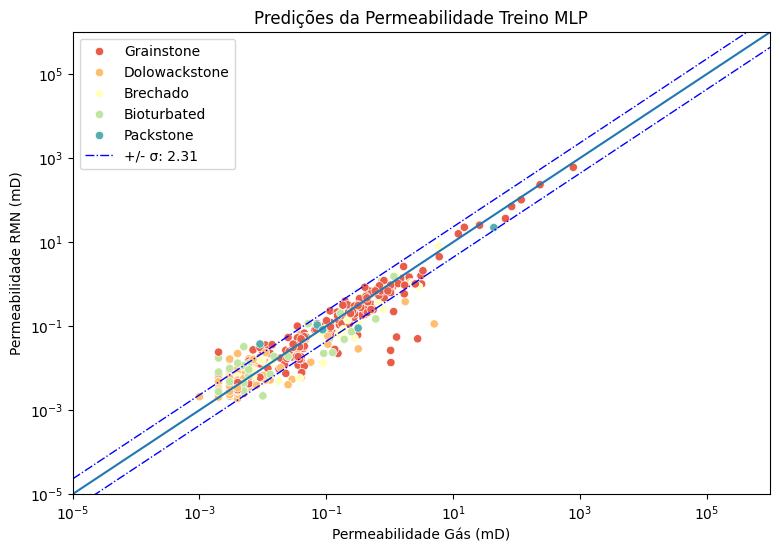

In [ ]:
titulo = 'Predições da Permeabilidade Treino MLP'
eixo_x = 'Permeabilidade Gás (mD)'
eixo_y = 'Permeabilidade RMN (mD)'
reta = pd.DataFrame({'x' : np.arange(1000000),
                         'y' : np.arange(1000000)})
plt.subplots(figsize = (9,6))
sns.scatterplot(data = treino,
                    x = 'Permeabilidade Gas',
                    y = previ_treino_mlp,
                    hue = 'Litofacies',
                    palette = 'Spectral')
sns.lineplot(data = reta,
                 x = 'x',
                 y = 'y')
plt.plot(reta['x'], reta['y'] * erro_sigma_treino_mlp, "b-.", linewidth=1)
plt.plot(reta['x'], reta['y'] / erro_sigma_treino_mlp, "b-.", linewidth=1, label = f'+/- \u03C3: {erro_sigma_treino_mlp:.2f}')

plt.xlabel(eixo_x)
plt.ylabel(eixo_y)
plt.title(titulo)
plt.xlim(0.00001,1000000)
plt.ylim(0.00001,1000000)
plt.legend(loc="upper left", fontsize=10)

plt.xscale('log')
plt.yscale('log')

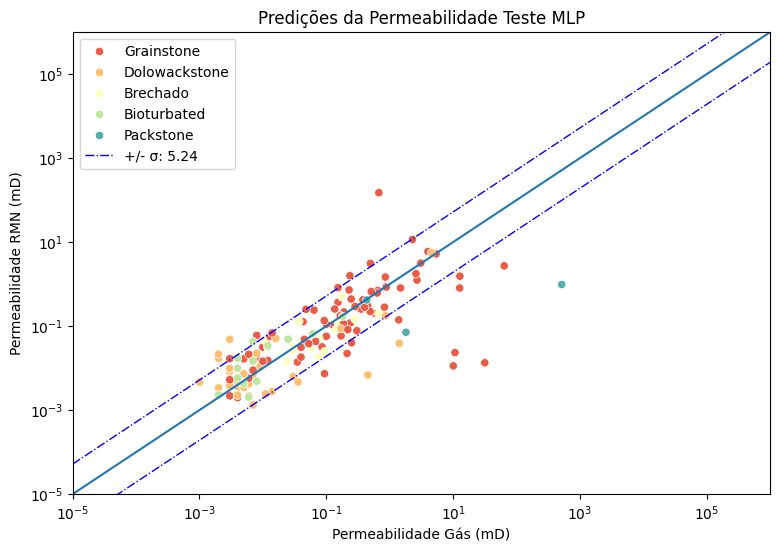

In [ ]:
titulo = 'Predições da Permeabilidade Teste MLP'
eixo_x = 'Permeabilidade Gás (mD)'
eixo_y = 'Permeabilidade RMN (mD)'
reta = pd.DataFrame({'x' : np.arange(1000000),
                         'y' : np.arange(1000000)})
plt.subplots(figsize = (9,6))
sns.scatterplot(data = teste,
                    x = 'Permeabilidade Gas',
                    y = previ_teste_mlp,
                    hue = 'Litofacies',
                    palette = 'Spectral')
sns.lineplot(data = reta,
                 x = 'x',
                 y = 'y')
plt.plot(reta['x'], reta['y'] * erro_sigma_teste_mlp, "b-.", linewidth=1)
plt.plot(reta['x'], reta['y'] / erro_sigma_teste_mlp, "b-.", linewidth=1, label = f'+/- \u03C3: {erro_sigma_teste_mlp:.2f}')

plt.xlabel(eixo_x)
plt.ylabel(eixo_y)
plt.title(titulo)
plt.xlim(0.00001,1000000)
plt.ylim(0.00001,1000000)
plt.legend(loc="upper left", fontsize=10)

plt.xscale('log')
plt.yscale('log')